O Desafio:

Como um Consultor de Ciência de Dados, você precisa criar um plano de ação para diminuir o número de clientes em churn e mostrar o retorno financeiro da sua solução.

Ao final da sua consultoria, você precisa entregar ao CEO da TopBottom um modelo em produção, que receberá uma base de clientes via API e retornará essa mesma base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Além disso, você precisará fornecer um relatório reportando a performance do seu modelo e o impacto financeiro da sua solução. Questões que o CEO e o time de Analytics gostariam de ver em seu relatório:

- Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
- Qual a Performance do modelo em classificar os clientes como churns?
- Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
- Uma possível ação para evitar que o cliente entre em churn é oferecer um cupom de desconto, ou alguma outro incentivo financeiro para ele renovar seu contrato por mais 12 meses.
Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
Os Dados

Features:
- RowNumber: O número da coluna
- CustomerID: Identificador único do cliente
- Surname: Sobrenome do cliente.
- CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.
- Geography: O país onde o cliente reside.
- Gender: O gênero do cliente.
- Age: A idade do cliente.
- Tenure: Número de anos que o cliente permaneceu ativo.
- Balance: Valor monetário que o cliente tem em sua conta bancária.
- NumOfProducts: O número de produtos comprado pelo cliente no banco.
- HasCrCard: Indica se o cliente possui ou não cartão de crédito.
- IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
- EstimateSalary: Estimativa do salário mensal do cliente.
- Exited: Indica se o cliente está ou não em Churn.

Exemplo de calculo:
- Segundo o time de Analytics da TopBank, cada cliente que possui essa conta bancária retorna um valor monetário de 15% do valor do seu salário estimado, se esse for menor que a média e 20% se esse salário for maior que a média, durante o período vigente de sua conta. Esse valor é calculado anualmente. 

- Por exemplo, se o salário mensal de um cliente é de R$1.000,00 e a média de todos os salários do banco é de R800. A empresa, portanto, fatura R 200 anualmente com esse cliente. Se esse cliente está no banco há 10 anos, a empresa já faturou R2.000,00 com suas transações e utilização da conta. 

Dados:
https://www.kaggle.com/mervetorkan/churndataset

Problema proposto:
https://sejaumdatascientist.com/predicao-de-churn/

#0.0. IMPORTS

In [1]:
!pip install Pycaret

In [2]:
!pip install boruta

In [3]:
import warnings
import random
import requests
import json
import math
import pickle
import os

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats

from boruta                    import BorutaPy
from IPython.core.display      import HTML
from sklearn.preprocessing     import LabelEncoder,RobustScaler,MinMaxScaler
from tabulate                  import tabulate
from IPython.display           import Image
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from flask                     import Flask, request,Response
from sklearn.feature_selection import RFE
from sklearn.metrics           import roc_curve, auc ,precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection   import StratifiedKFold,cross_val_predict
from sklearn.metrics           import confusion_matrix 
from sklearn.model_selection   import RandomizedSearchCV
from sklearn.ensemble          import RandomForestRegressor,ExtraTreesClassifier
from imblearn.over_sampling    import RandomOverSampler
from pycaret.classification    import*

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


##0.1 Helper Functions

In [4]:
def feature_importance(x_train,y_train):

  #model
  model = RandomForestRegressor()

  #fit 
  model.fit(x_train, y_train)

  #get importance
  importance = model.feature_importances_

  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
  #plot feature importance
  plt.bar([x for x in range(len(importance))], importance)

  return plt.show()


def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  

def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta


def numeric_correlation(numerics,data):

  columns=numerics.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);  
  ax.set_title('Correlation between numerical features',fontsize=14)

  return ax


def model_performance(y_test,yhat,name):

  dataframe=pd.DataFrame({ 'ModelName':    name,                                                                                                   
                           'Precision':    precision_score(y_test,yhat),                           
                           'Recall':       recall_score(y_test,yhat),
                           'F1Score':      f1_score(y_test,yhat),
                           'Accuracy':     accuracy_score(y_test,yhat)
                         },index=[0])
  return dataframe


def cross_validation(data,kfold,model_name,model,variable_response):
  
  precision_list=[]
  f1_score_list=[]
  recall_list=[]
  accuracy_list=[]
  

  fim=[]
  inicio=[]  
  razao=data.index.max()/kfold
  for i in range(1,kfold+1):
    fim.append(round(razao*i,2))
    inicio.append(round((razao*i)-razao,2))

  for k in range(0,kfold):

    #Start and end  for validation
    validation_start=inicio[k]
    validation_end=fim[k]

    #Filtering in dataset
    aux=data[(data.index>=validation_start) & (data.index<=validation_end)]
    training=data.drop(aux.index,axis=0)
    validation=data[(data.index>=validation_start) & (data.index<=validation_end)]


    #Training and validation dataset

    #Training
    xtraining=training.drop([variable_response],axis=1)
    ytraining=training[variable_response]

    #Validation
    xvalidation=validation.drop([variable_response],axis=1)
    yvalidation=validation[variable_response]


    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    performaces=model_performance(yvalidation,yhat,model_name)
    
    #performance of each KFold iteration
    precision_list.append(performaces['Precision'])
    f1_score_list.append(performaces['F1Score'])
    recall_list.append(performaces['Recall'])
    accuracy_list.append(performaces['Accuracy'])
    


  return pd.DataFrame({ 'ModelName':     model_name,                        
                        'PrecisionCV':   np.round(np.mean(precision_list),2).astype(str)+ '+/-' + np.round(np.std(precision_list),2).astype(str),
                        'RecallCV':      np.round(np.mean(recall_list),2).astype(str)+ '+/-'    + np.round(np.std(recall_list),2).astype(str),
                        'F1ScoreCV':     np.round(np.mean(f1_score_list),2).astype(str)+ '+/-' +  np.round(np.std(f1_score_list),2).astype(str),                        
                        'AccuracyCV':    np.round(np.mean(accuracy_list),2).astype(str)+ '+/-' +  np.round(np.std(accuracy_list),2).astype(str)
                       
                        },index=[0])
  

def categorical_correlation(data):

  #selected
  a=data.select_dtypes(include='object')

  #list one , all correlations
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #list two , correlations by features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2


def descriptive_statistics(data):

  #selected
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  # Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['Attributes','Min','Max','range','Mean','Median','Std','Skew','kurtosis']) 

  return aux


def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def plot_numeric_categorical(feature,feature_response,data):
  
  plt.subplot(2,2,1)
  ax=sns.barplot(x=feature_response,y=feature,data=df4)
  ax.figure.set_size_inches(12,6)

  plt.subplot(2,2,2)
  sns.boxplot(x=feature_response,y=feature,data=df4)

  plt.subplot(2,2,3)
  numeric_categorical(feature,feature_response,df4)

  return ax


def numeric_categorical(feature,feature_response,data):

  aux=data.copy()
  aux[feature_response]=aux[feature_response].apply(lambda x: 1 if x=='yes' else 0)
  correlation=aux[[feature,feature_response]].corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);

  return ax


def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


##0.2 Loading Data

In [5]:
df_raw=pd.read_csv('/content/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0. DESCRIPTION OF THE DATA

In [6]:
df1=df_raw.copy()

##1.1. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 10000
Number of cols: 14


##1.2. Data Types

In [8]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

##1.3. Check NA

In [9]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

##1.4. Change types

In [10]:
#HasCrCard
df1['HasCrCard']=df1['HasCrCard'].apply(lambda x: 'sim' if x==1 else 'nao')

#IsActiveMember
df1['IsActiveMember']=df1['IsActiveMember'].apply(lambda x: 'sim' if x==1 else 'nao')

#Exited
df1['Exited']=df1['Exited'].apply(lambda x: 'sim' if x==1 else 'nao')

##1.5. Descriptive Statistical

In [11]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
num_attributes.drop(['CustomerId','RowNumber'],axis=1,inplace=True)

cat_attributes=df1.select_dtypes(include=['object'])

###1.5.1. Numerical Attributes

In [12]:
descriptive_statistics(num_attributes)

,Attributes,Min,Max,range,Mean,Median,Std,Skew,kurtosis
0,CreditScore,350.00,850.00,300.53,650.53,652.00,96.65,-0.07,-0.43
1,Age,18.00,92.00,20.92,38.92,37.00,10.49,1.01,1.40
2,Tenure,0.00,10.00,5.01,5.01,5.00,2.89,0.01,-1.17
3,Balance,0.00,250898.09,76485.89,76485.89,97198.54,62394.29,-0.14,-1.49
4,NumOfProducts,1.00,4.00,0.53,1.53,1.00,0.58,0.75,0.58
5,EstimatedSalary,11.58,199992.48,100078.66,100090.24,100193.91,57507.62,0.00,-1.18


Conclusões:
- Tenure , Quanto menor o  número de anos ativo, maior é a chance de Churn ?
- Balance, Quanto menor o valor na conta , maior e a chance de Churn ?
- EstimatedSalary, Quanto menor o salário estimado , maior é a chance de Churn ?

###1.5.2. Categorical attributes


In [13]:
cat_attributes.drop(['Surname'],axis=1,inplace=True)

#number of classes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

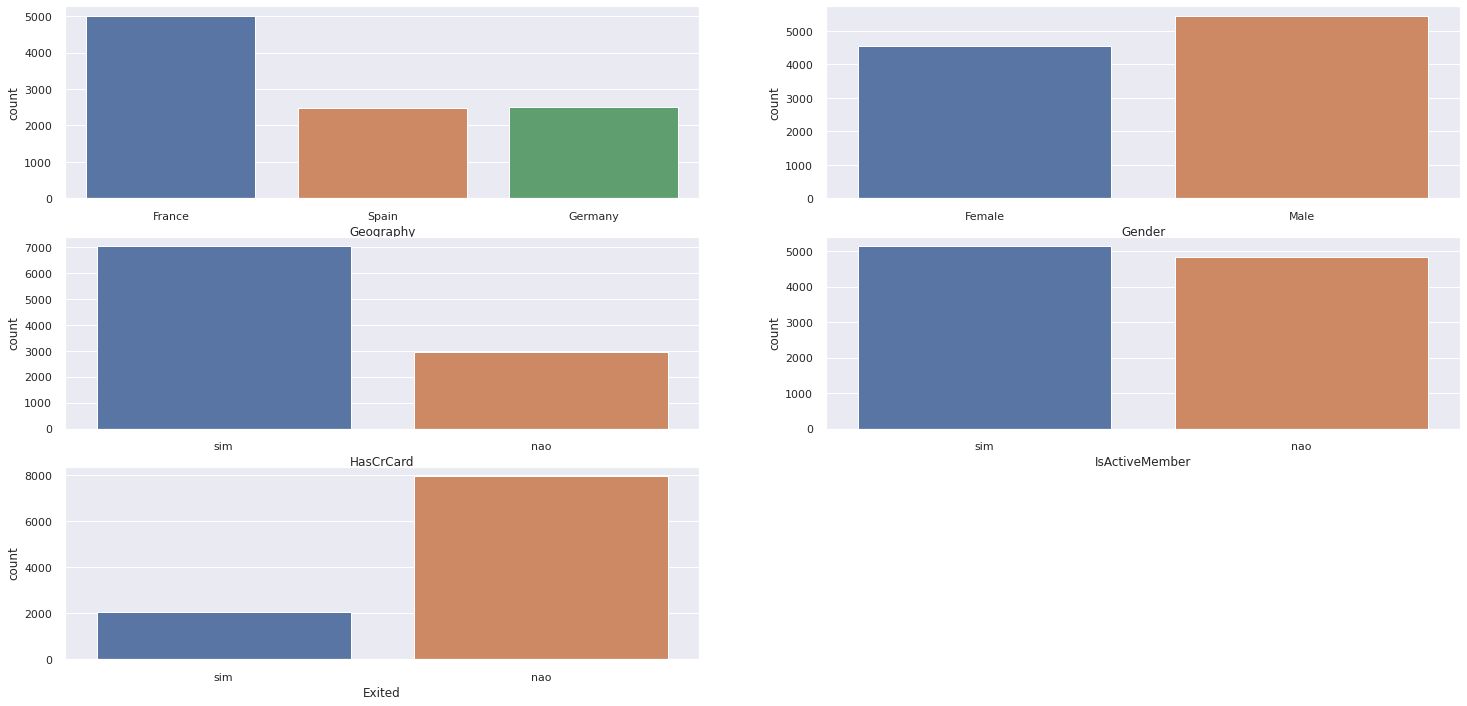

In [14]:
#Geography
plt.subplot(3,2,1)
sns.countplot(cat_attributes['Geography'])

#Gender
plt.subplot(3,2,2)
sns.countplot(cat_attributes['Gender'])

#HasCrCard
plt.subplot(3,2,3)
sns.countplot(cat_attributes['HasCrCard'])

#IsActiveMember
plt.subplot(3,2,4)
sns.countplot(cat_attributes['IsActiveMember'])

#Exited
plt.subplot(3,2,5)
sns.countplot(cat_attributes['Exited'])

#2.0. FEATURE ENGINEERING

In [15]:
df2=df1.copy()

##2.1. Hypothesis mind map

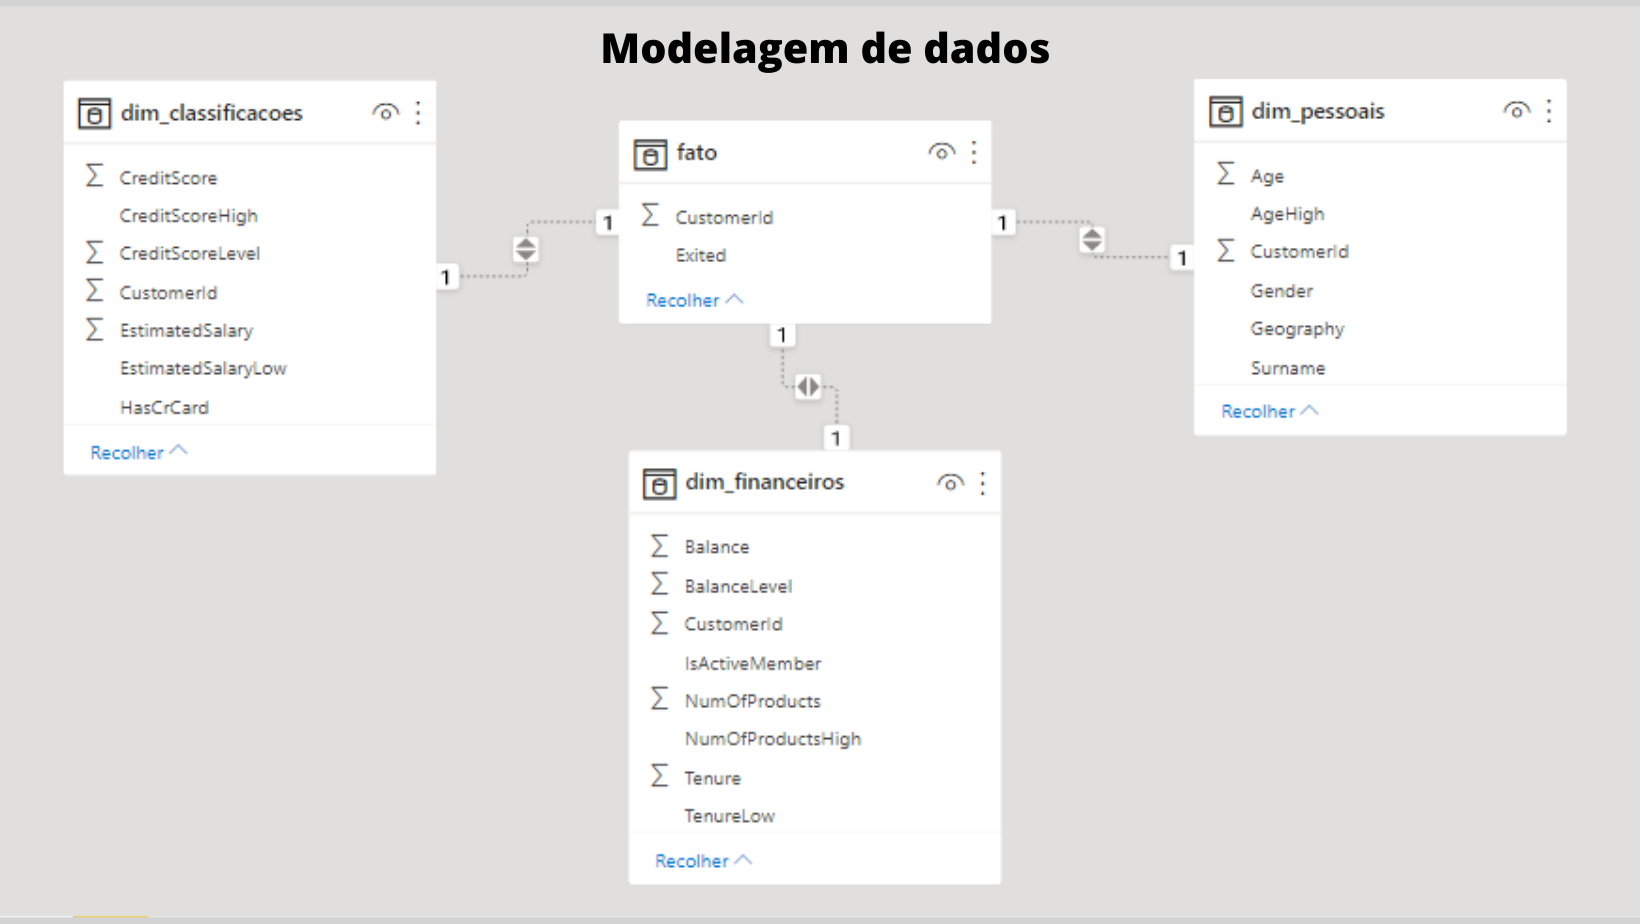

In [16]:
Image('/content/mind_map.png')

##2.2. Creation of hypotheses

### 2.1.1. Classificações

**1.** Pontuações menores que 600 de CreditScore tem maior chance de entrerem em Churn.

**2.** Os clientes que não possuem cartão de crétido tem maior chance de entrarem em Churn.

 **3.** Os clientes que a empresa estimou salários abaixo de 100000 , tem maior chance de entrarem em Churn.

**4.** Os clientes com CrediScore acima de 800 , tem maiores chances de entrarem em Churn.

### 2.1.2. Pessoais

**1.** Clientes de gênero masculino, tem maior chance de entrar em Churn.

 **2.** Clientes com idades acima dos 50, possuem maiores chances de entrar em Churn. 

**3.** Clientes residentes na espanha tem maiores chances de entrarem em Churn.

### 2.1.3. Finançeiros

**1.** Clientes com tempo de atividade abaixo de 5 anos, possuem maiores chances de entrarem em Churn.

**2.** Clientes com valor abaixo de 70000 em suas contas, possuem maiores chances de entrarem em Churn.

 **3.** Clientes com pelo menos 2 produtos comprados ,possuem menores chances de entrarem em Churn.

**4.** Os clientes que não fazem pelomenos uma movimentação durante 12 meses, possuem maiores chances de entrarem em Churn.

**5.** Os clientes com o valor de Balance menores que 50000 , tem maores chances de entrarem em Churn.

##2.3 Final list of hypotheses

**H1-**Pontuações menores que 600 de CreditScore tem maiores chances de entrarem em Churn.

**H2-**Os clientes que não possuem cartão de crédito tem maiores chances de entrarem em Churn.

**H3-**Os clientes que a empresa estimou salários abaixo de 100000, tem maiores chances de entrarem em Churn.

**H4-**Clientes de gênero masculino, tem maiores chances de entrarem em Churn.

**H5-**Clientes com idades acima dos 50, tem maiores chances de entrarem em Churn.

**H6-**Clientes residentes na espanha ,tem maiores chances de entrarem em Churn.

**H7-**Clientes com tempo de atividade abaixo de 5 anos, possuem maiores chances de entrarem em Churn.

**H8-**Clientes com valor abaixo de 70 000 em suas contas, possuem maiores chances de entrarem em Churn.

**H9-**Clientes com pelo menos 2 produtos comprados, possuem menores chances de entrarem em Churn.

**H10-**Os clientes que não fazem pelo menos uma movimentação durante 12 meses, possuem maiores chances de entrarem em Churn.

**H11-**Os clientes com o valor de Balance menores que 50000, tem maores chances de entrarem em Churn.

**H12-**Os clientes com CrediScore acima de 800, tem maiores chances de entrarem em Churn.

##2.4 Feature Engineering

In [17]:
#CreditScoreHigh
df2['CreditScoreHigh']=df2['CreditScore'].apply(lambda x: 'maior' if x>=600 else 'menor')

#EstimatedSalaryLow
df2['EstimatedSalaryLow']=df2['EstimatedSalary'].apply(lambda x: 'maior' if x>=100000 else 'menor')

#AgeHigh
df2['AgeHigh']=df2['Age'].apply(lambda x: 'maior' if x>=50 else 'menor')

#TenureLow
df2['TenureLow']=df2['Tenure'].apply(lambda x: 'menor' if x<5 else 'maior')

#BalanceLow
df2['BalanceLow']=df2['Balance'].apply(lambda x: 'menor' if x<70000 else 'maior')

#NumOfProductsHigh
df2['NumOfProductsHigh']=df2['NumOfProducts'].apply(lambda x: 'menor' if x<2 else 'maior')

#CreditScoreLevel
df2['Exited']=df2['Exited'].apply(lambda x : 1 if x=='sim' else 0)
df2['CreditScoreLevel']=df2['CreditScore'].apply(lambda x:     1 if x<=400 else
                                                               2 if (x>400) & (x<=500) else
                                                               3 if (x>500)& (x<=600) else
                                                               4 if (x>600) & (x<=700) else
                                                               5 if (x>700) & (x<=800) else
                                                               6 if x>800 else x)

#BalanceLevel
df2['BalanceLevel']=df2['Balance'].apply(lambda x:             1 if x<=50000                else
                                                               2 if (x>50000) & (x<=100000) else
                                                               3 if (x>100000)& (x<=150000) else
                                                               4 if (x>150000) & (x<=200000) else
                                                               5 if (x>200000) & (x<=250000) else
                                                               6 if x>250000 else x)

#AgeLevel
df2['AgeLevel']=df2['Age'].apply(lambda x:                 1 if x<=20            else
                                                               2 if (x>20) & (x<=40) else
                                                               3 if (x>40)& (x<=60)  else
                                                               4 if (x>60) & (x<=80) else                                                               
                                                               5 if x>80 else x)

#3.0. VARIABLES FILTERING

In [18]:
df3=df2.copy()

## 3.1. Columns Filtering

In [19]:
#RowNumber
df3.drop(['RowNumber'],axis=1,inplace=True)

#4.0. EXPLORATORY DATA ANALYSIS

In [20]:
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

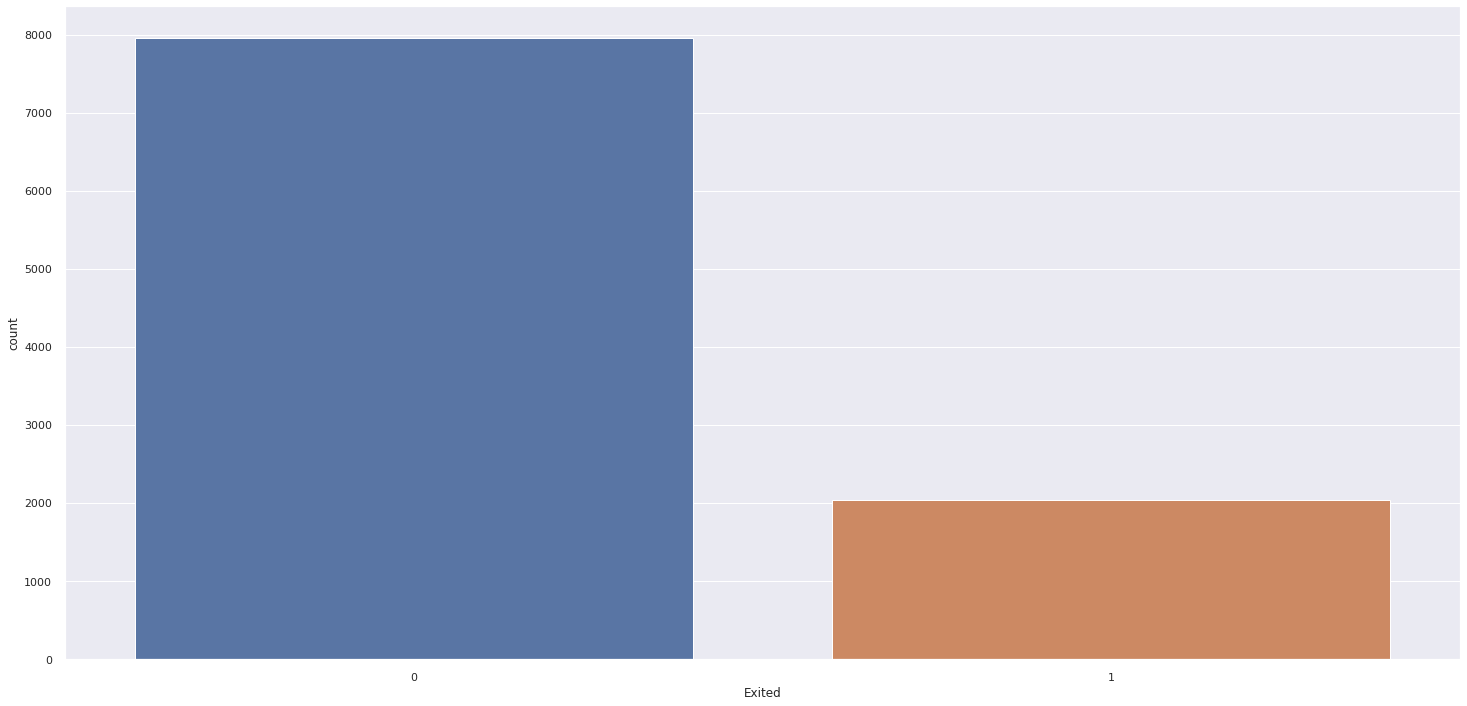

In [21]:
ax=sns.countplot(df4['Exited'])

###4.1.2. Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc18d897d10>,
      dtype=object)

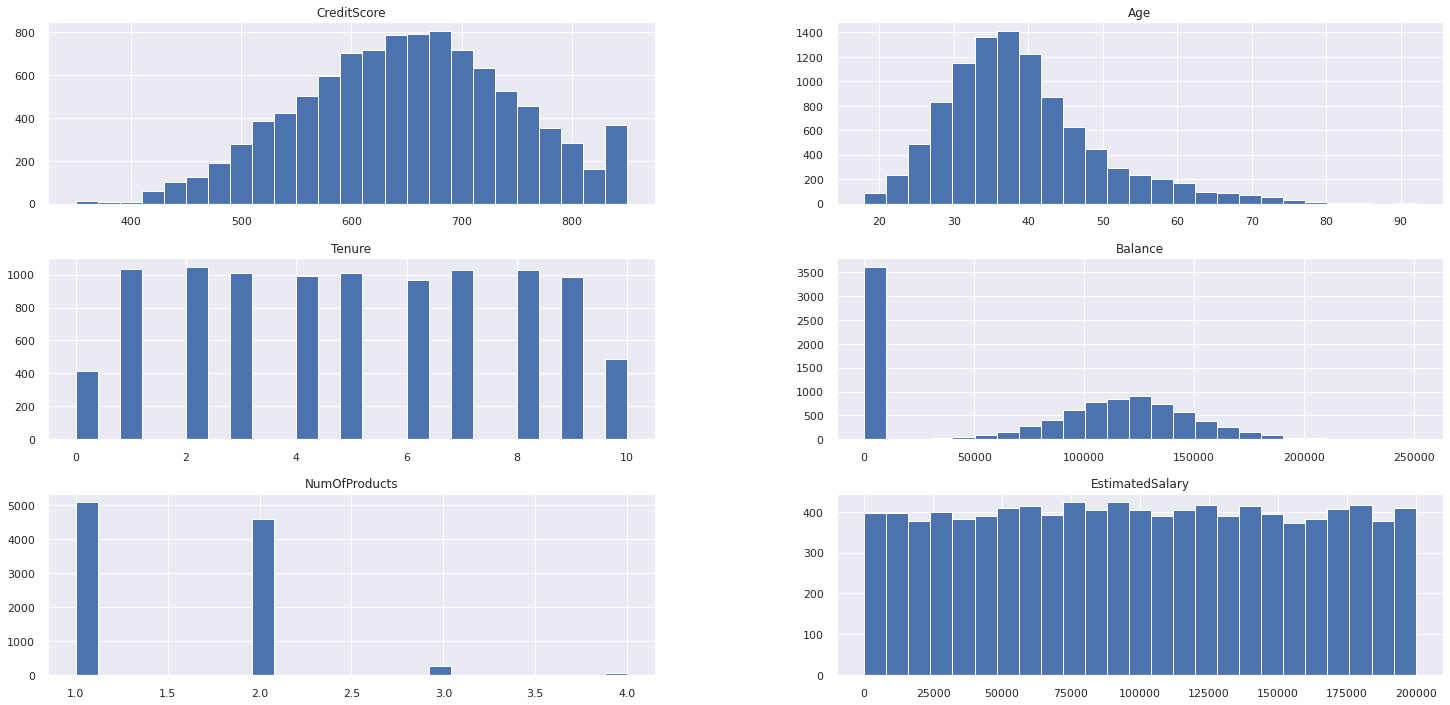

In [22]:
aux=df4[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']].copy()
aux.hist(bins=25)

Investigar:
- CreditScore > 800
- Balance próximo de 0

###4.1.3. Categorical Variable

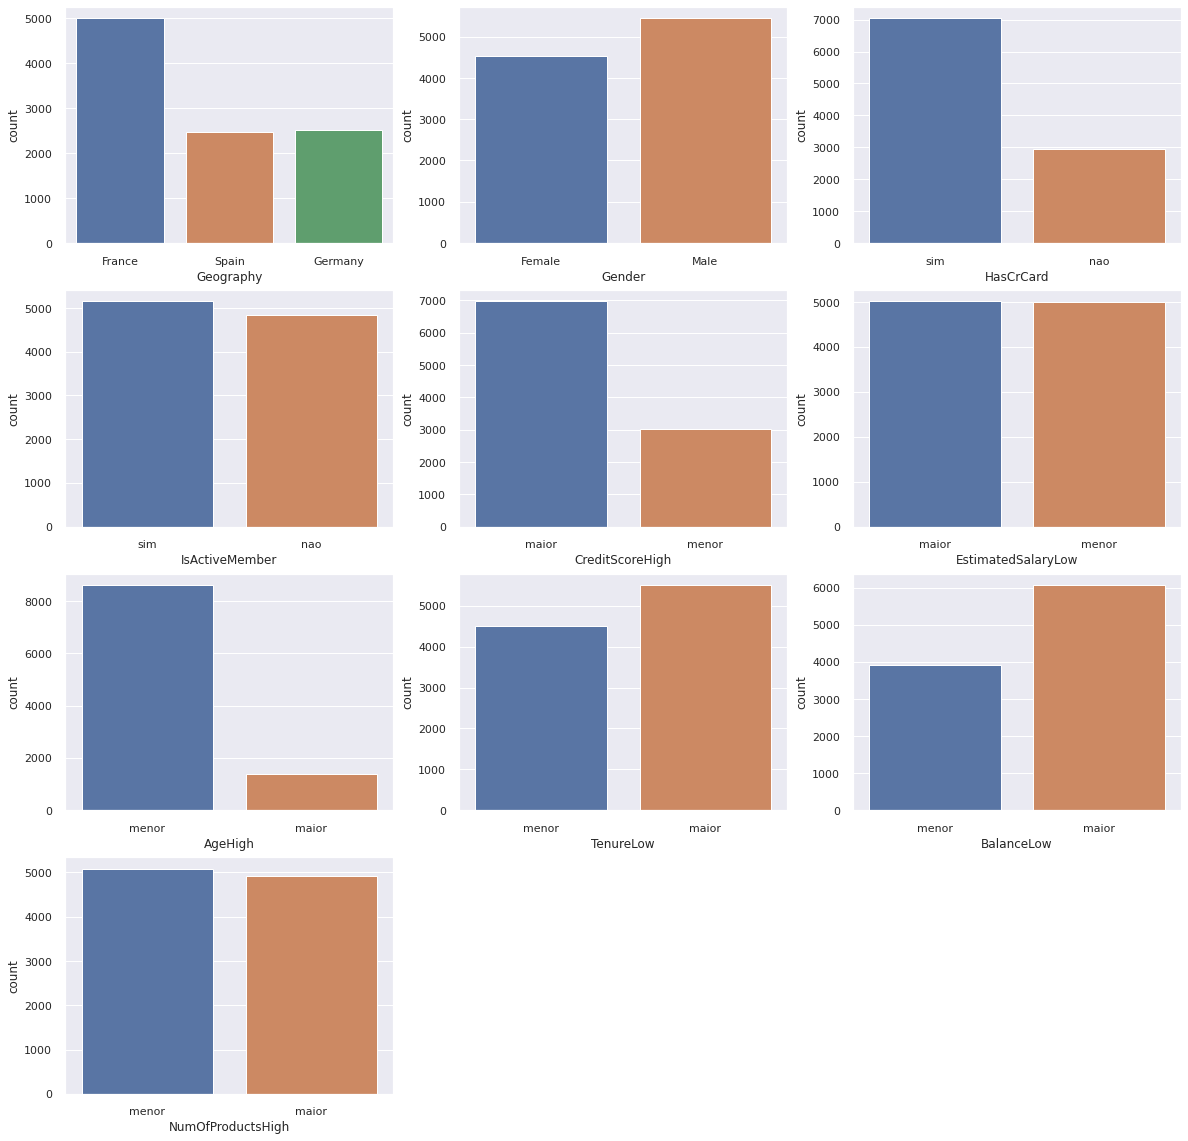

In [23]:
aux=df4[['Geography','Gender','HasCrCard','IsActiveMember','CreditScoreHigh','EstimatedSalaryLow',
         'AgeHigh','TenureLow','BalanceLow','NumOfProductsHigh']].copy()

#Geography
plt.subplot(4,3,1)
ax=sns.countplot(aux['Geography'])
ax.figure.set_size_inches(20,20)

#Gender
plt.subplot(4,3,2)
ax=sns.countplot(aux['Gender'])

#HasCrCard
plt.subplot(4,3,3)
ax=sns.countplot(aux['HasCrCard'])

#IsActiveMember
plt.subplot(4,3,4)
ax=sns.countplot(aux['IsActiveMember'])

#CreditScoreHigh
plt.subplot(4,3,5)
ax=sns.countplot(aux['CreditScoreHigh'])

#EstimatedSalaryLow
plt.subplot(4,3,6)
ax=sns.countplot(aux['EstimatedSalaryLow'])

#AgeHigh
plt.subplot(4,3,7)
ax=sns.countplot(aux['AgeHigh'])

#TenureLow
plt.subplot(4,3,8)
ax=sns.countplot(aux['TenureLow'])

#BalanceLow
plt.subplot(4,3,9)
ax=sns.countplot(aux['BalanceLow'])

#NumOfProductsHigh
plt.subplot(4,3,10)
ax=sns.countplot(aux['NumOfProductsHigh'])

  Conclusões:
  - França é o maior cliente.
  - A maior parte dos clientes possuem cartão de crédito.
  - A maior parte dos clientes tem um CreditScore alto.
  

## 4.2 Bivariate Analysis

### ***H1***. Pontuações menores que 600 de CreditScore, tem maiores chances de entrarem em Churn.(True-Relevance 2)

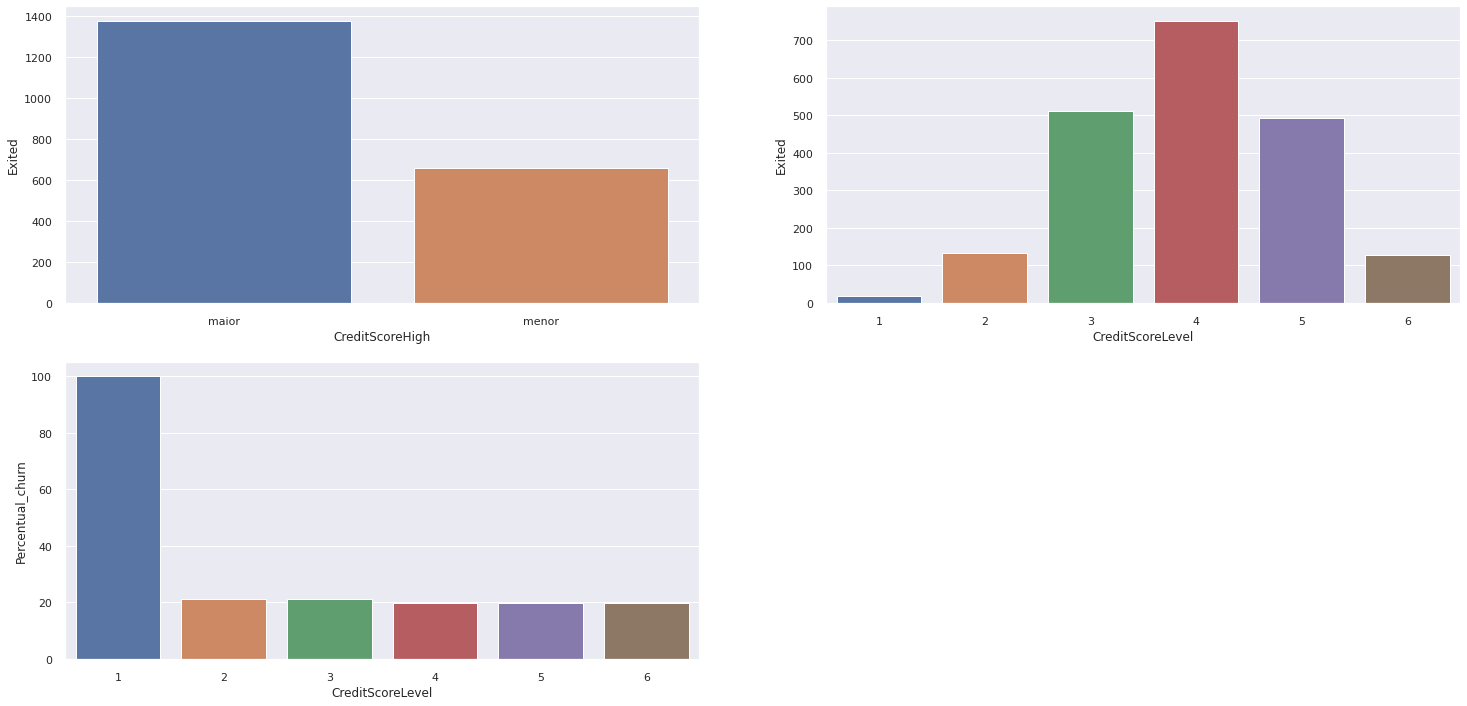

In [24]:
churn=df4[df4['Exited']==1]

plt.subplot(2,2,1)
aux=churn[['CreditScoreHigh','Exited']].groupby('CreditScoreHigh').count().reset_index()
ax=sns.barplot(x='CreditScoreHigh',y='Exited',data=aux)

plt.subplot(2,2,2)
aux=churn[['CreditScoreLevel','Exited']].groupby('CreditScoreLevel').count().reset_index()
ax=sns.barplot(x='CreditScoreLevel',y='Exited',data=aux)

plt.subplot(2,2,3)
aux=df4[['CreditScoreLevel','Exited']].groupby(['CreditScoreLevel']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['CreditScoreLevel','Exited']].groupby('CreditScoreLevel').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
aux=sns.barplot(x='CreditScoreLevel',y='Percentual_churn',data=aux)

Observações:
CreditScoreLevel: 4, corresponde de (600 há 700)

### ***H2***. Os clientes que não possuem cartão de crétido tem maiores chances de entrarem em Churn (False-Relevance 2).


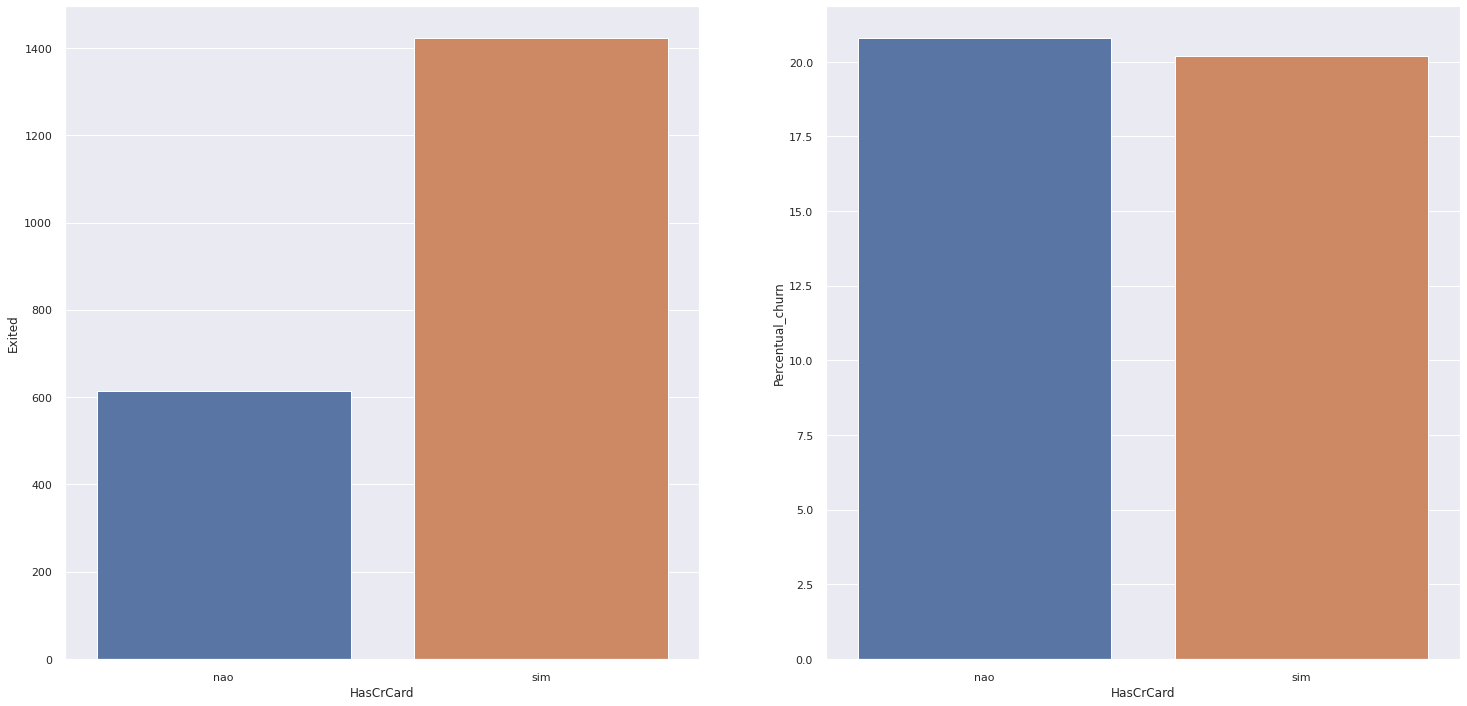

In [25]:
plt.subplot(1,2,1)
aux=churn[['HasCrCard','Exited']].groupby('HasCrCard').count().reset_index()
ax=sns.barplot(x='HasCrCard',y='Exited',data=aux)

plt.subplot(1,2,2)
aux=df4[['HasCrCard','Exited']].groupby(['HasCrCard']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['HasCrCard','Exited']].groupby('HasCrCard').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
aux=sns.barplot(x='HasCrCard',y='Percentual_churn',data=aux)

### ***H3***. Os clientes que a empresa estimou salários abaixo de 100000 , tem maiores chances de entrarem em Churn.(False-Relevance 2)

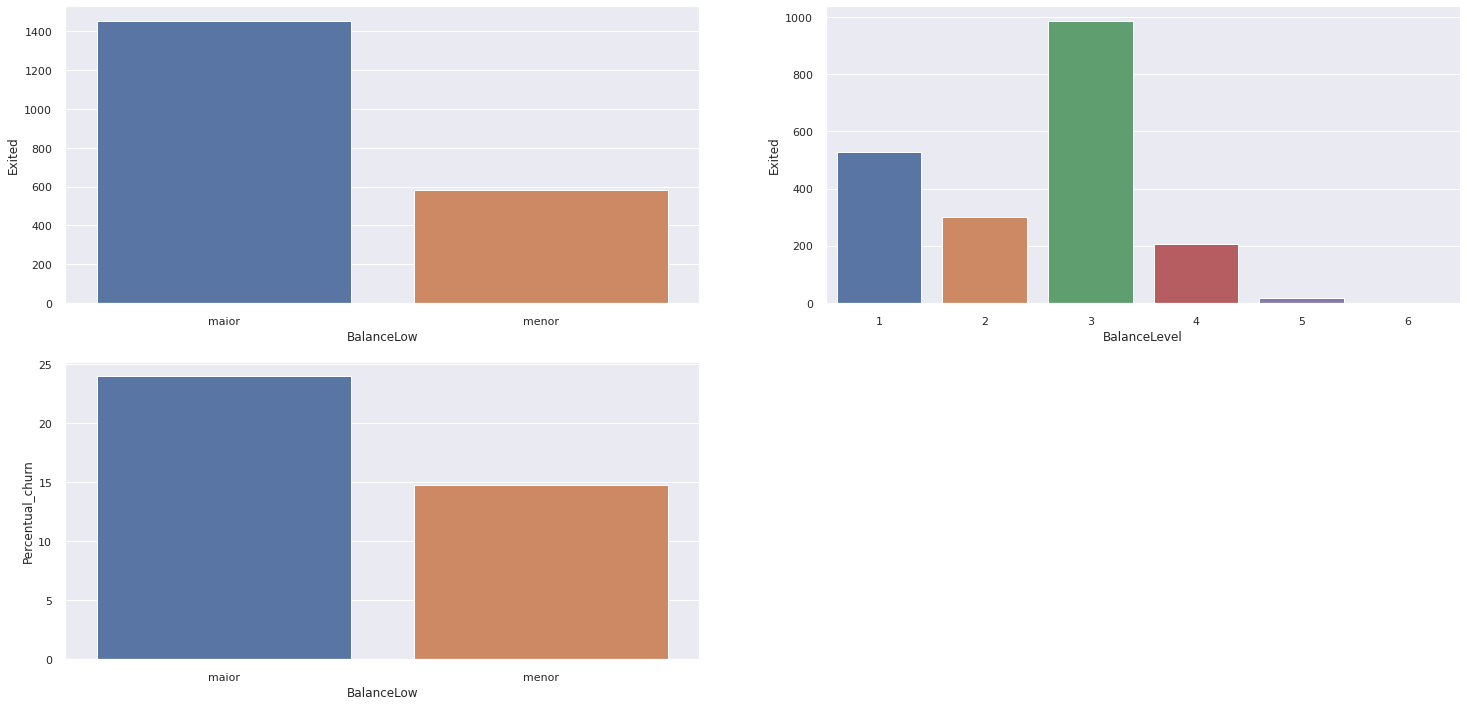

In [26]:
plt.subplot(2,2,1)
aux=churn[['BalanceLow','Exited']].groupby('BalanceLow').count().reset_index()
ax=sns.barplot(x='BalanceLow',y='Exited',data=aux)

plt.subplot(2,2,2)
aux=churn[['BalanceLevel','Exited']].groupby('BalanceLevel').count().reset_index()
ax=sns.barplot(x='BalanceLevel',y='Exited',data=aux)

plt.subplot(2,2,3)
aux=df4[['BalanceLow','Exited']].groupby(['BalanceLow']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['BalanceLow','Exited']].groupby('BalanceLow').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='BalanceLow',y='Percentual_churn',data=aux)

Conclusões:
- O intervalo de Balance de 100000 há 150000 , possuí a maior quantidade de Churns.

### ***H4***. Clientes de gênero masculino, tem maior chance de entrar em Churn.(False-Relevance 1)

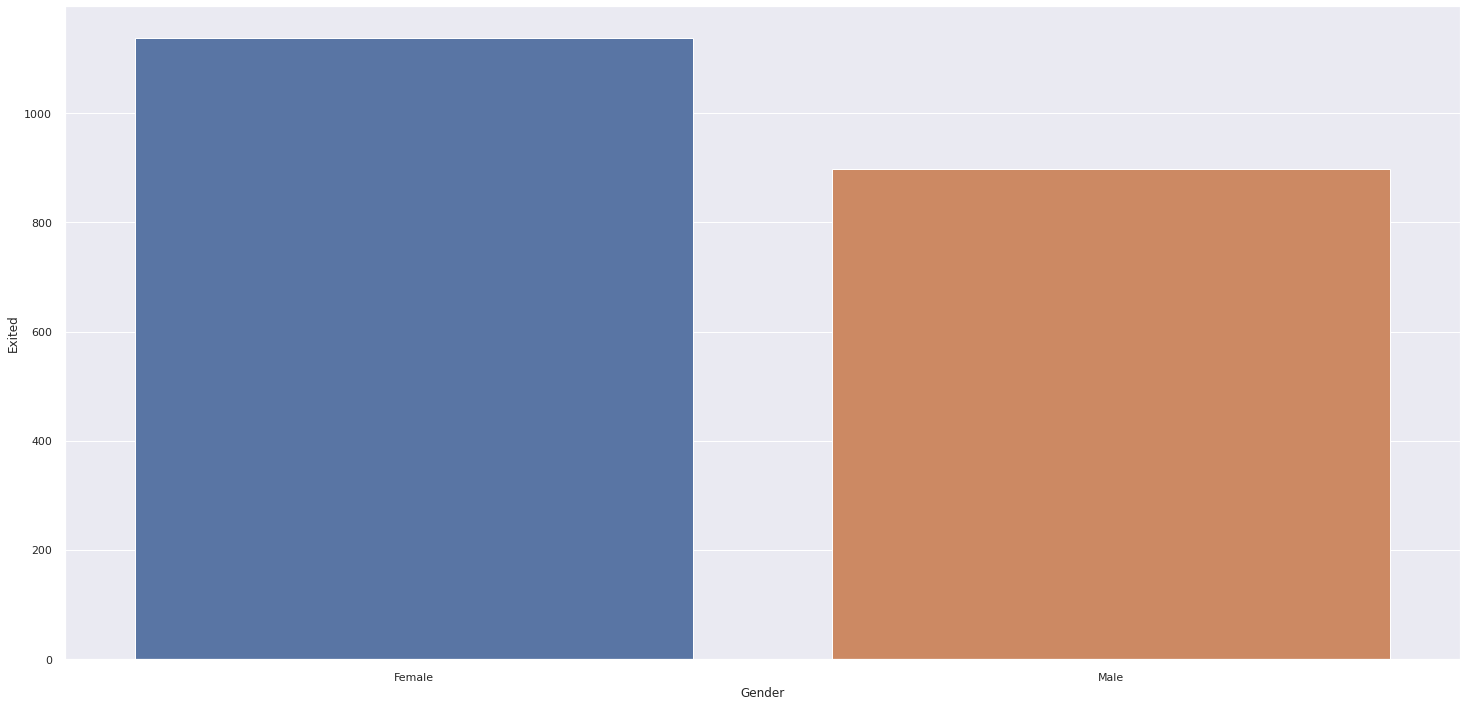

In [27]:
aux=churn[['Gender','Exited']].groupby('Gender').count().reset_index()
ax=sns.barplot(x='Gender',y='Exited',data=aux)

### ***H5***. Clientes com idades acima dos 50, possuem maiores chances de entrar em Churn.(False-Relevance 2)


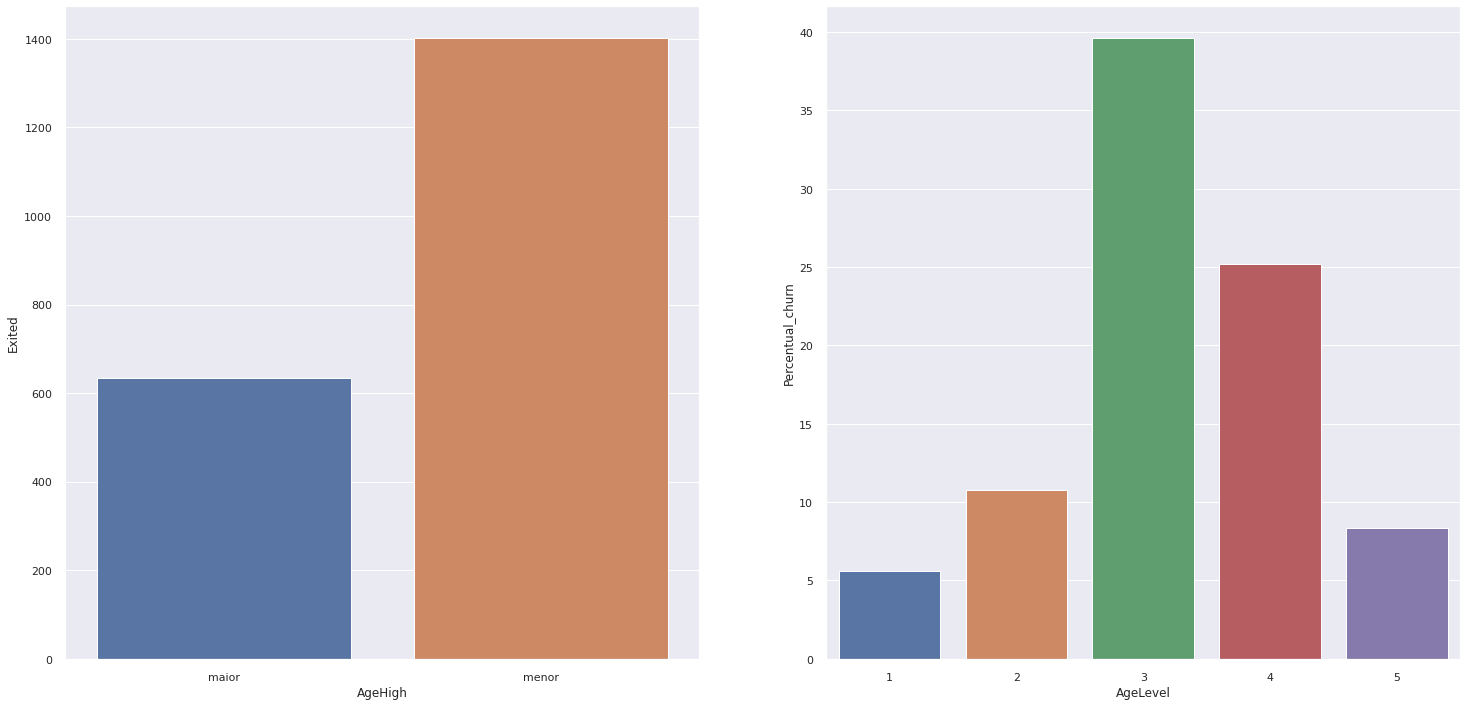

In [28]:
plt.subplot(1,2,1)
aux=churn[['AgeHigh','Exited']].groupby('AgeHigh').count().reset_index()
ax=sns.barplot(x='AgeHigh',y='Exited',data=aux)

plt.subplot(1,2,2)
aux=df4[['AgeLevel','Exited']].groupby(['AgeLevel']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['AgeLevel','Exited']].groupby('AgeLevel').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='AgeLevel',y='Percentual_churn',data=aux)

### ***H6***. Clientes residentes na espanha tem maiores chances de entrarem em Churn.(False-Relevance 1)


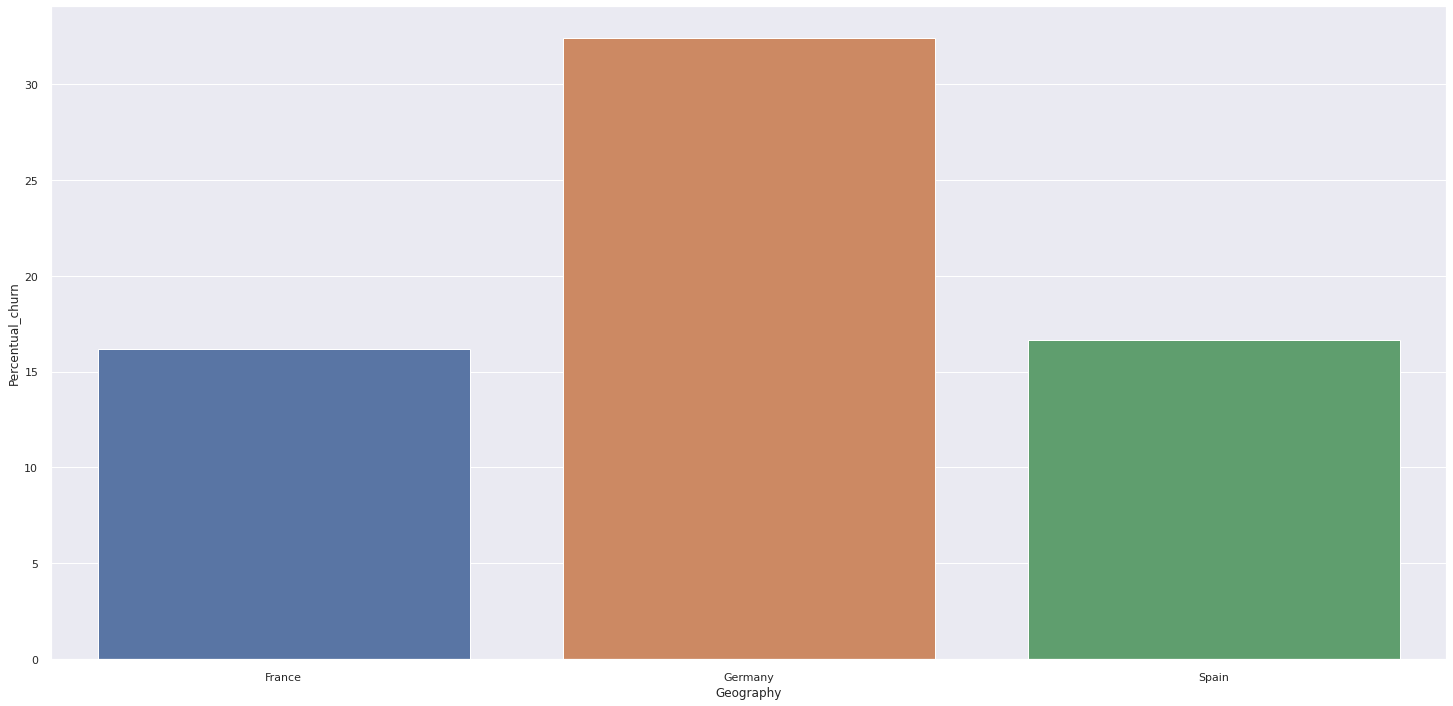

In [29]:
aux=df4[['Geography','Exited']].groupby(['Geography']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['Geography','Exited']].groupby('Geography').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='Geography',y='Percentual_churn',data=aux)

### ***H7***. Clientes com tempo de atividade abaixo de 5 anos, possuem maiores chances de entrarem em Churn.(False- Relevance 1)

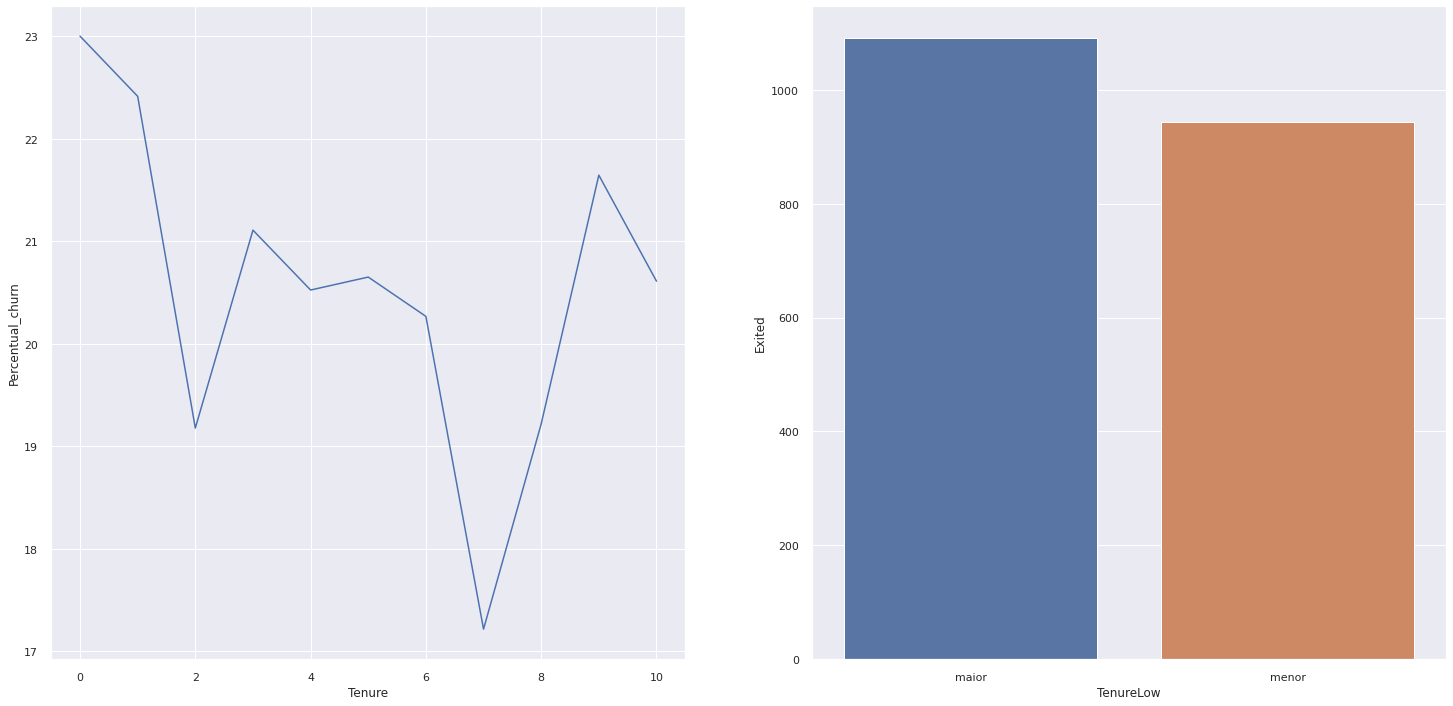

In [30]:
plt.subplot(1,2,1)
aux=df4[['Tenure','Exited']].groupby(['Tenure']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['Tenure','Exited']].groupby('Tenure').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.lineplot(x='Tenure',y='Percentual_churn',data=aux)

plt.subplot(1,2,2)
aux=churn[['TenureLow','Exited']].groupby('TenureLow').count().reset_index()
ax=sns.barplot(x='TenureLow',y='Exited',data=aux)

### ***H8***. Clientes com valor abaixo de 70000 em suas contas, possuem maiores chances de entrarem em Churn. (False-Relevance 2)

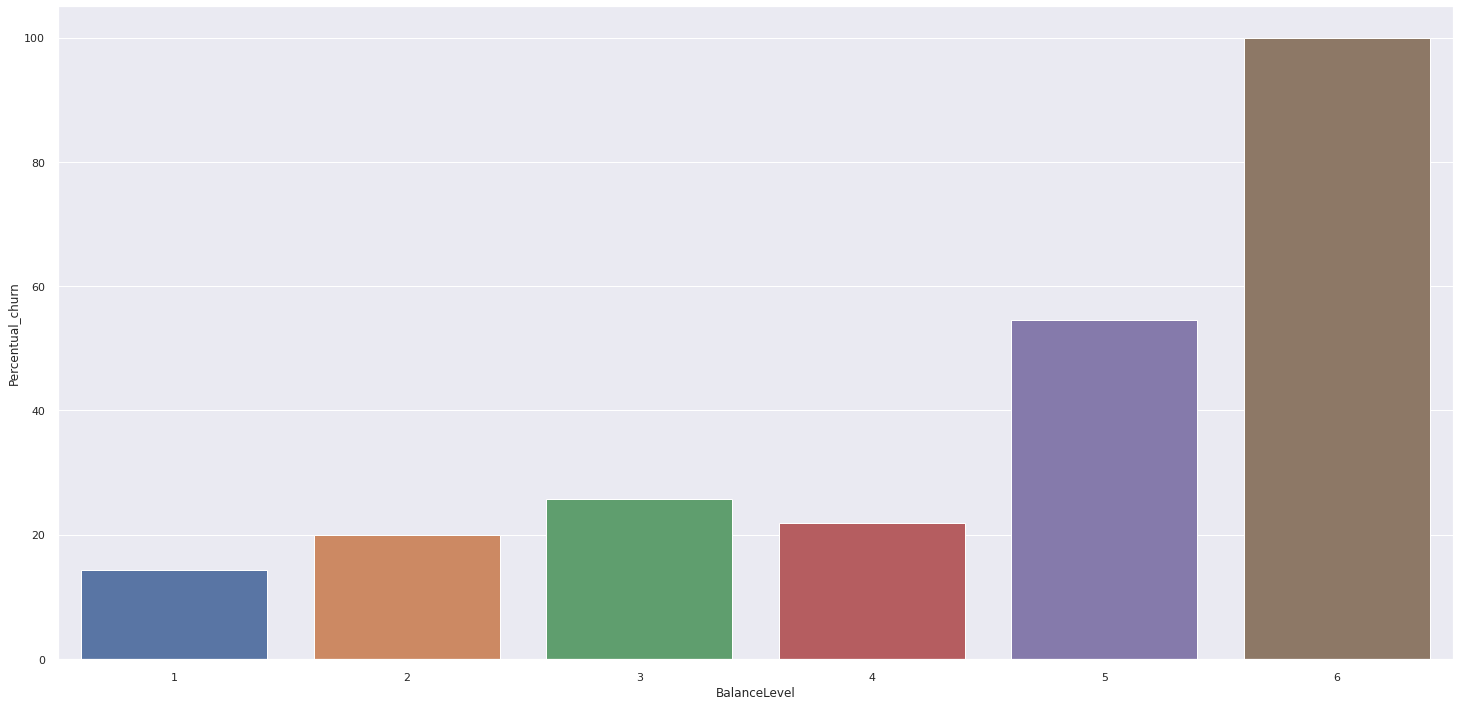

In [31]:
aux=df4[['BalanceLevel','Exited']].groupby(['BalanceLevel']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['BalanceLevel','Exited']].groupby('BalanceLevel').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='BalanceLevel',y='Percentual_churn',data=aux)

### ***H9***. Clientes com pelo menos 2 produtos comprados ,possuem menores chances de entrarem em Churn.(True-Relevance 2)

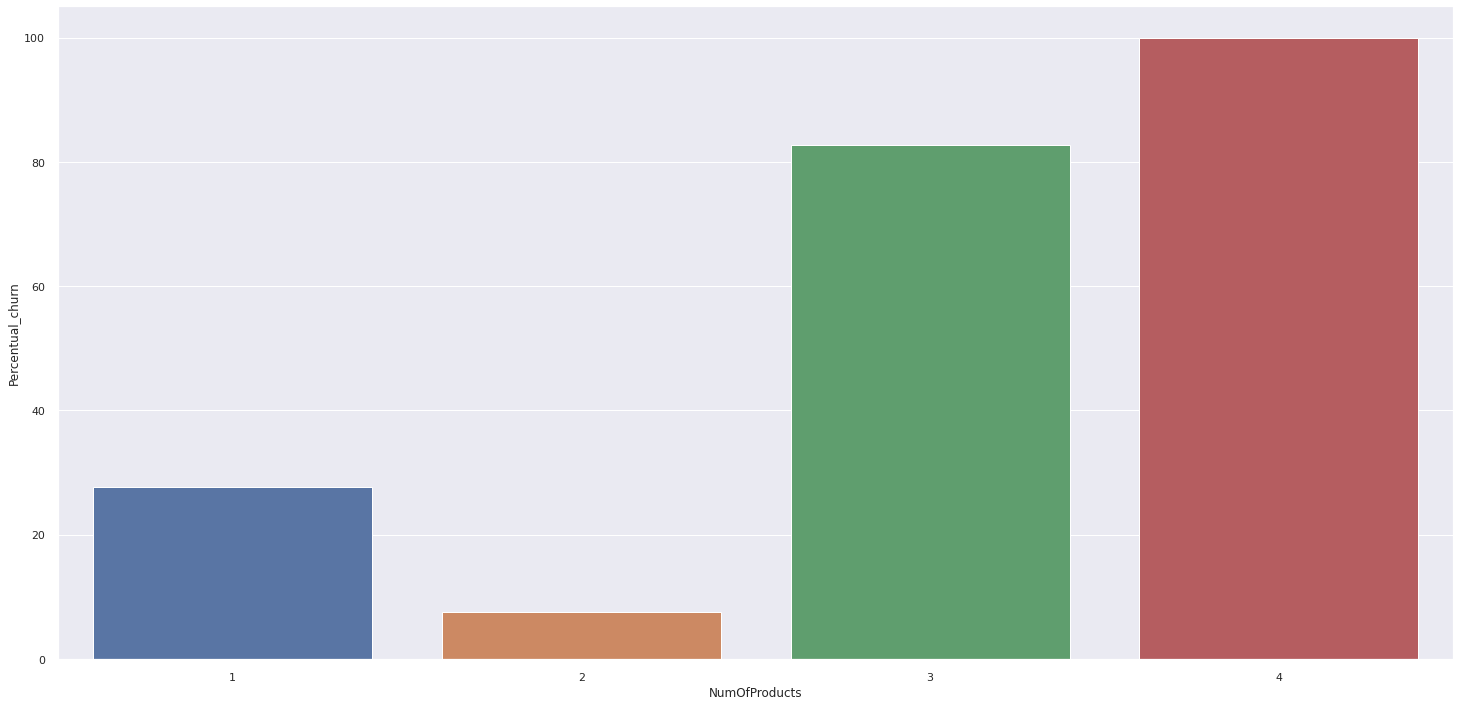

In [32]:
aux=df4[['NumOfProducts','Exited']].groupby(['NumOfProducts']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['NumOfProducts','Exited']].groupby('NumOfProducts').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='NumOfProducts',y='Percentual_churn',data=aux)

### ***H10***. Os clientes que não fazem pelomenos uma movimentação durante 12 meses, possuem maiores chances de entrarem em Churn.(True-Relevance 2)

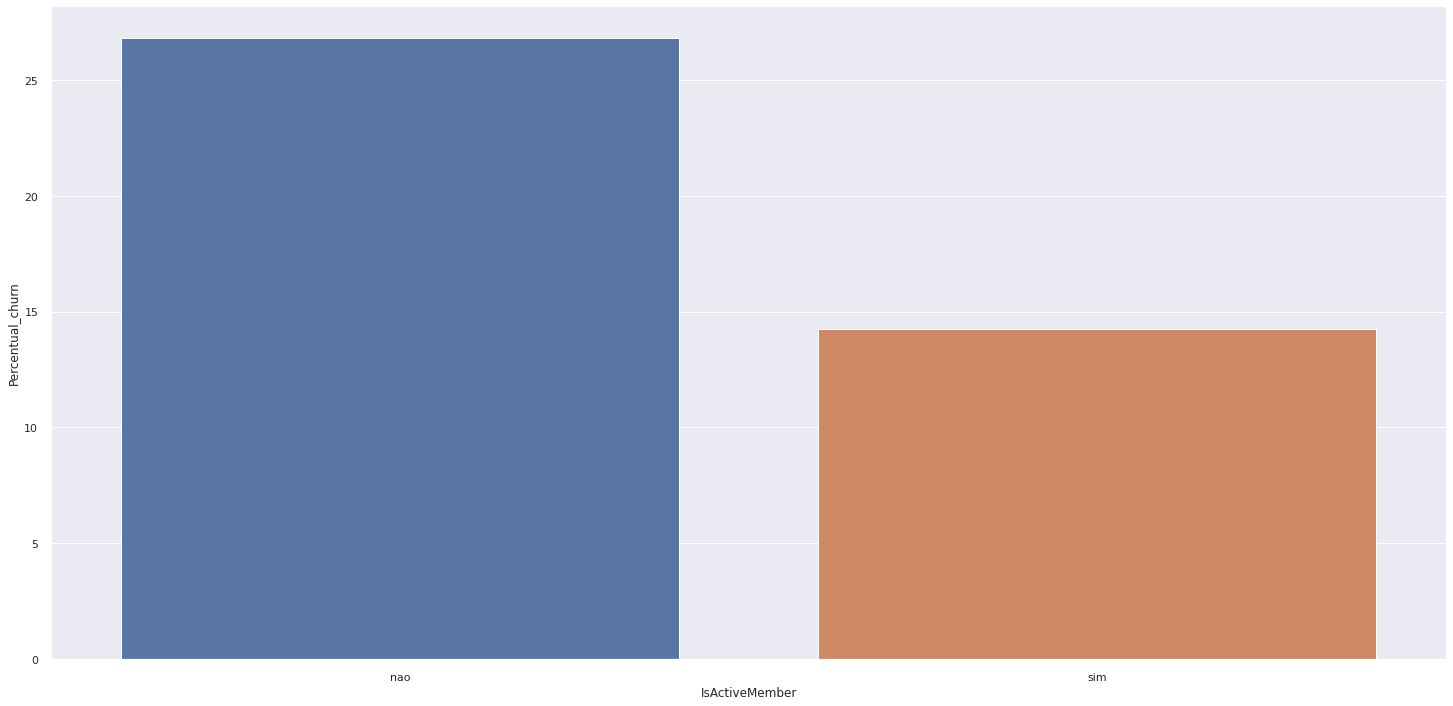

In [33]:
aux=df4[['IsActiveMember','Exited']].groupby(['IsActiveMember']).count().reset_index()
aux['churn']=df4[df4['Exited']==1][['IsActiveMember','Exited']].groupby('IsActiveMember').count().reset_index()['Exited']
aux['Percentual_churn']=(aux['churn']*100)/aux['Exited']
ax=sns.barplot(x='IsActiveMember',y='Percentual_churn',data=aux)

### ***H11***. Os clientes com o valor de Balance maiores que 50000, tem maores chances de entrarem em Churn.(True-Relevance 1)

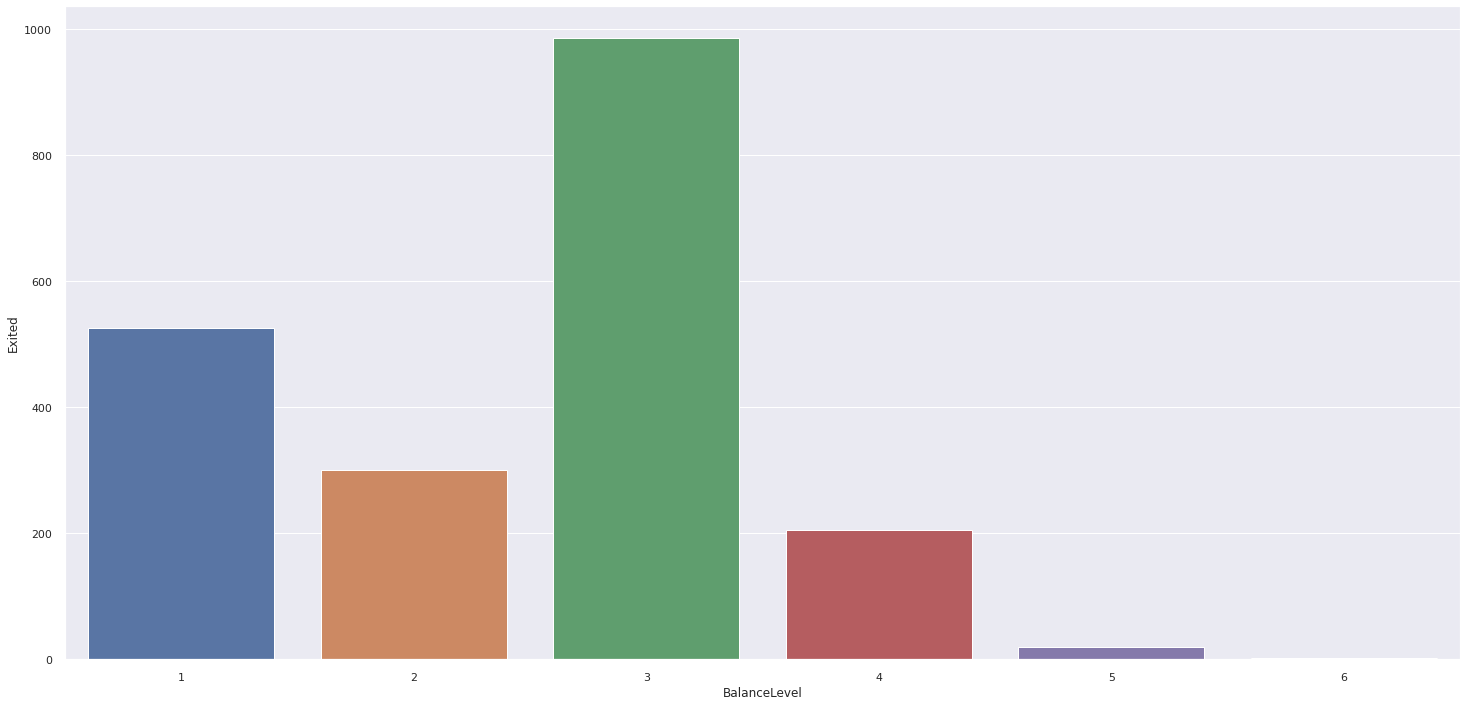

In [34]:
aux=churn[['BalanceLevel','Exited']].groupby('BalanceLevel').count().reset_index()
ax=sns.barplot(data=aux,x='BalanceLevel',y='Exited')

### ***H12***. Os clientes com CrediScore acima de 800, tem maiores chances de entrarem em Churn.(False-Relevance 1)

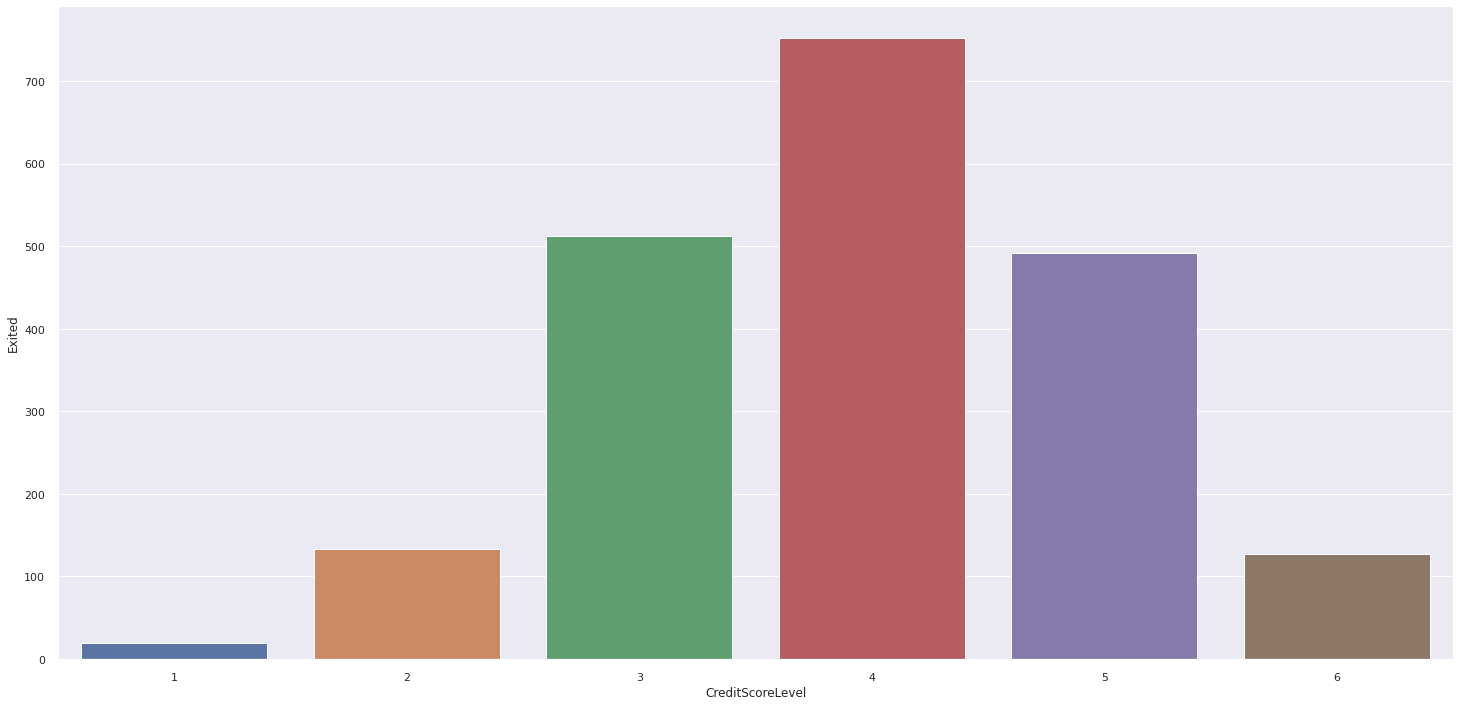

In [35]:
aux=churn[['CreditScoreLevel','Exited']].groupby('CreditScoreLevel').count().reset_index()
ax=sns.barplot(data=aux,x='CreditScoreLevel',y='Exited')

### 4.2.1 Summary of hypotheses

In [36]:
tab=[['Hypotheses','Status'  ,'Relevance(1-3)'],
     ['H1'        ,'True'   ,'2'],
     ['H2'        ,'False'   ,'2'],
     ['H3'        ,'False'   ,'2'],
     ['H4'        ,'False'   ,'1'],
     ['H5'        ,'False'   ,'2'],
     ['H6'        ,'False'   ,'1'],
     ['H7'        ,'False'   ,'1'],
     ['H8'        ,'False'   ,'2'],
     ['H9'        ,'True'    ,'2'],
     ['H10'       ,'True'    ,'2'],
     ['H11'       ,'True'    ,'1'],
     ['H12'       ,'False'   ,'1']]

print(tabulate(tab,headers='firstrow'))

Hypotheses    Status      Relevance(1-3)
------------  --------  ----------------
H1            True                     2
H2            False                    2
H3            False                    2
H4            False                    1
H5            False                    2
H6            False                    1
H7            False                    1
H8            False                    2
H9            True                     2
H10           True                     2
H11           True                     1
H12           False                    1


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

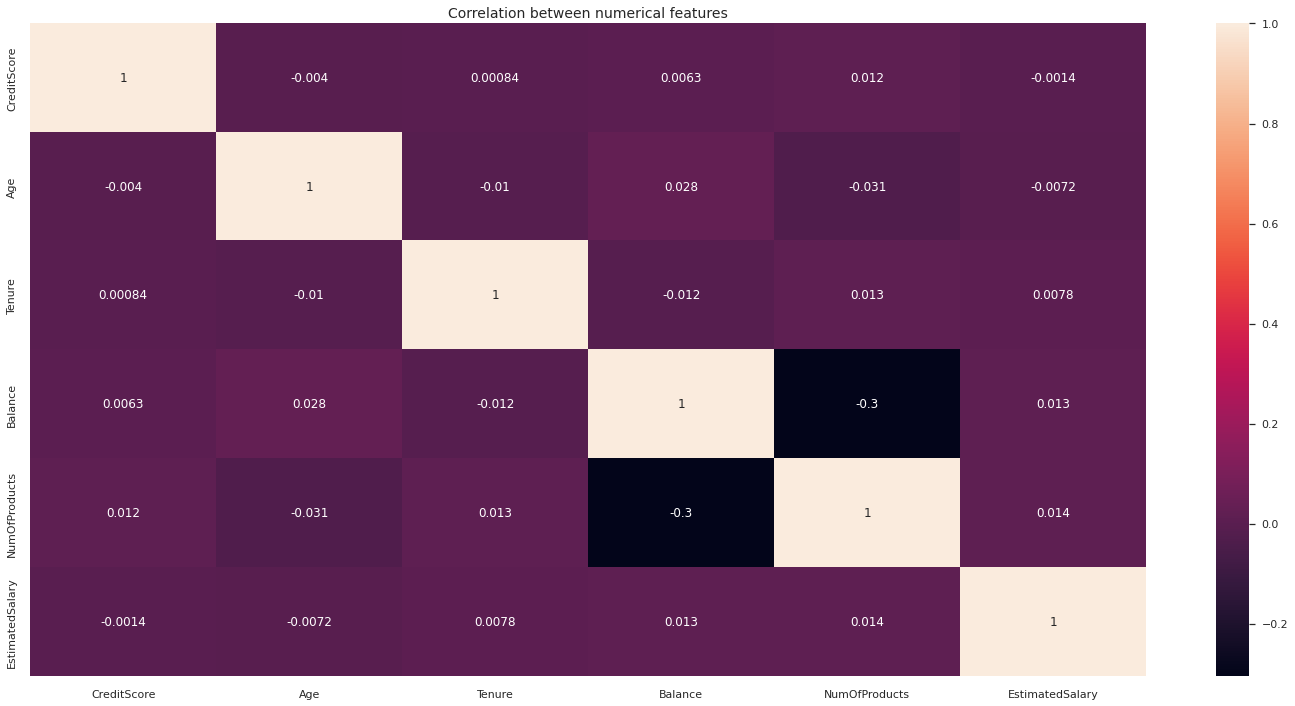

In [37]:
numeric_correlation(num_attributes,df4)

###4.3.2. Categorical Atributes

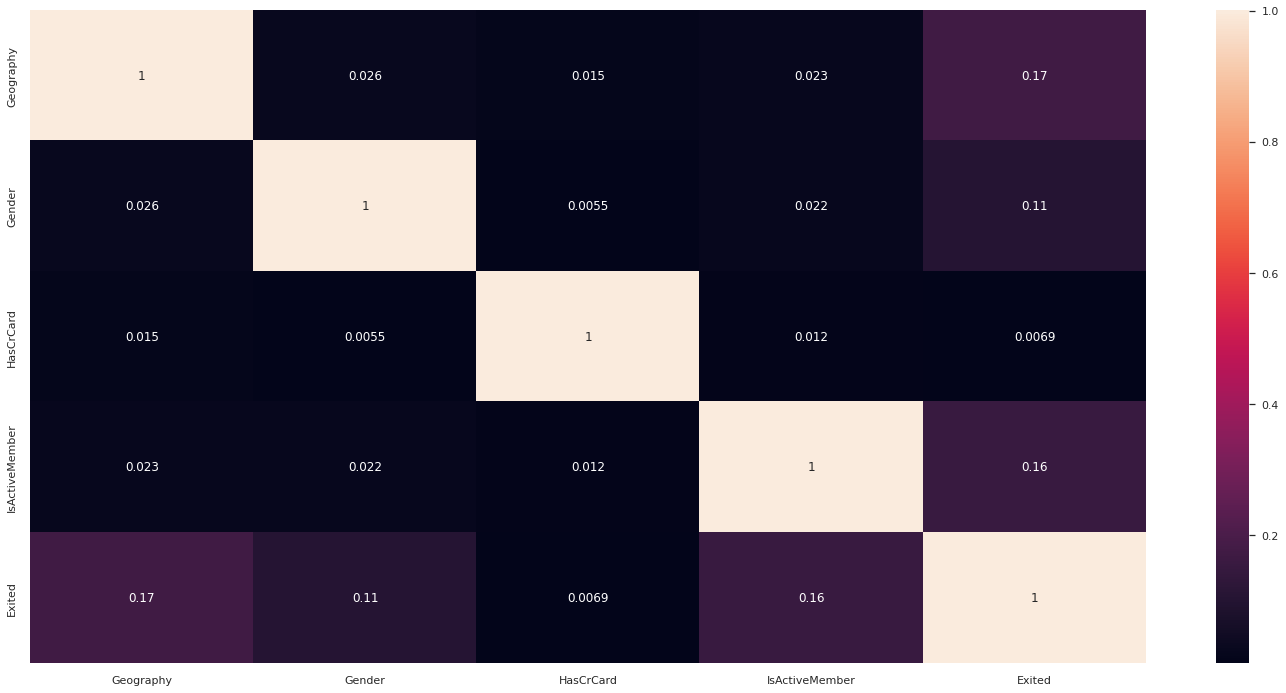

In [38]:
lista=categorical_correlation(cat_attributes)

d=pd.DataFrame({'Geography':         lista[0],
                'Gender':            lista[1],
                'HasCrCard':         lista[2],
                'IsActiveMember':    lista[3],
                'Exited':            lista[4]
                 })

d=d.set_index(d.columns)
ax=sns.heatmap(d,annot=True)

#5.0. DATA PREPARATION

In [39]:
df5=df4.copy()

##5.1. Rescaling

In [40]:
rs=RobustScaler()
mm=MinMaxScaler()

#CreditScore
df5['CreditScore']=mm.fit_transform(df5[['CreditScore']].values)
pickle.dump(mm,open('/content/CreditScore_scaler.pkl','wb'))

#Age
df5['Age']=rs.fit_transform(df5[['Age']].values)
pickle.dump(rs,open('/content/Age_scaler.pkl','wb'))

#Tenure
df5['Tenure']=mm.fit_transform(df5[['Tenure']].values)
pickle.dump(mm,open('/content/Tenure_scaler.pkl','wb'))

#Balance
df5['Balance']=mm.fit_transform(df5[['Balance']].values)
pickle.dump(mm,open('/content/Balance_scaler.pkl','wb'))

#NumOfProducts
df5['NumOfProducts']=mm.fit_transform(df5[['NumOfProducts']].values)
pickle.dump(mm,open('/content/NumOfProducts_scaler.pkl','wb'))

#EstimatedSalary
df5['EstimatedSalary']=mm.fit_transform(df5[['EstimatedSalary']].values)
pickle.dump(mm,open('/content/EstimatedSalary_scaler.pkl','wb'))

## 5.2. Transformation

###5.2.1. Encoding

In [41]:
##LabelEncoder
le=LabelEncoder()

#Gender
df5['Gender']=le.fit_transform(df5['Gender'])

#HasCrCard
df5['HasCrCard']=le.fit_transform(df5['HasCrCard'])

#IsActiveMember
df5['IsActiveMember']=le.fit_transform(df5['IsActiveMember'])
pickle.dump(le,open('/content/IsActiveMember_scaler.pkl','wb'))

#CreditScoreHigh
df5['CreditScoreHigh']=le.fit_transform(df5['CreditScoreHigh'])

#EstimatedSalaryLow
df5['EstimatedSalaryLow']=le.fit_transform(df5['EstimatedSalaryLow'])

#AgeHigh
df5['AgeHigh']=le.fit_transform(df5['AgeHigh'])

#TenureLow
df5['TenureLow']=le.fit_transform(df5['TenureLow'])

#BalanceLow
df5['BalanceLow']=le.fit_transform(df5['BalanceLow'])

#NumOfProductsHigh
df5['NumOfProductsHigh']=le.fit_transform(df5['NumOfProductsHigh'])

#CustomerId
df5['CustomerId']=le.fit_transform(df5['CustomerId'])
pickle.dump(le,open('/content/CustomerId_scaler.pkl','wb'))

#Surname
df5['Surname']=le.fit_transform(df5['Surname'])

#Geography
df5['Geography']=le.fit_transform(df5['Geography'])

#Exited
df5['Exited']=le.fit_transform(df5['Exited'])

#OrdinalEnconding
#CreditScoreLevel
df5['CreditScoreLevel']=df5['CreditScoreLevel']/10

#BalanceLevel
df5['BalanceLevel']=df5['BalanceLevel']/10

#6.0. FEATURE SELECTION

In [42]:
df6=df5.copy()

##6.1. Split dataframe into training and test dataset.

In [43]:
y=df5['Exited']
x=df5.drop(['Exited'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=100,test_size=0.2)

##6.2. Boruta as feature selector


In [44]:
boruta=boruta(x_train,y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
I

##6.2.1. Best Features from Boruta

In [45]:
best_features(boruta,x_train)

['CustomerId', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember']

##6.3. Manual Feature selection


In [46]:
cols_selected_boruta=[ 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember']

#Columns to add
feat_to_add=['Exited']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#7.0. MACHINE LEARNING MODELLING

Feature: 0, Score: 0.34698
Feature: 1, Score: 0.46152
Feature: 2, Score: 0.14565
Feature: 3, Score: 0.04585


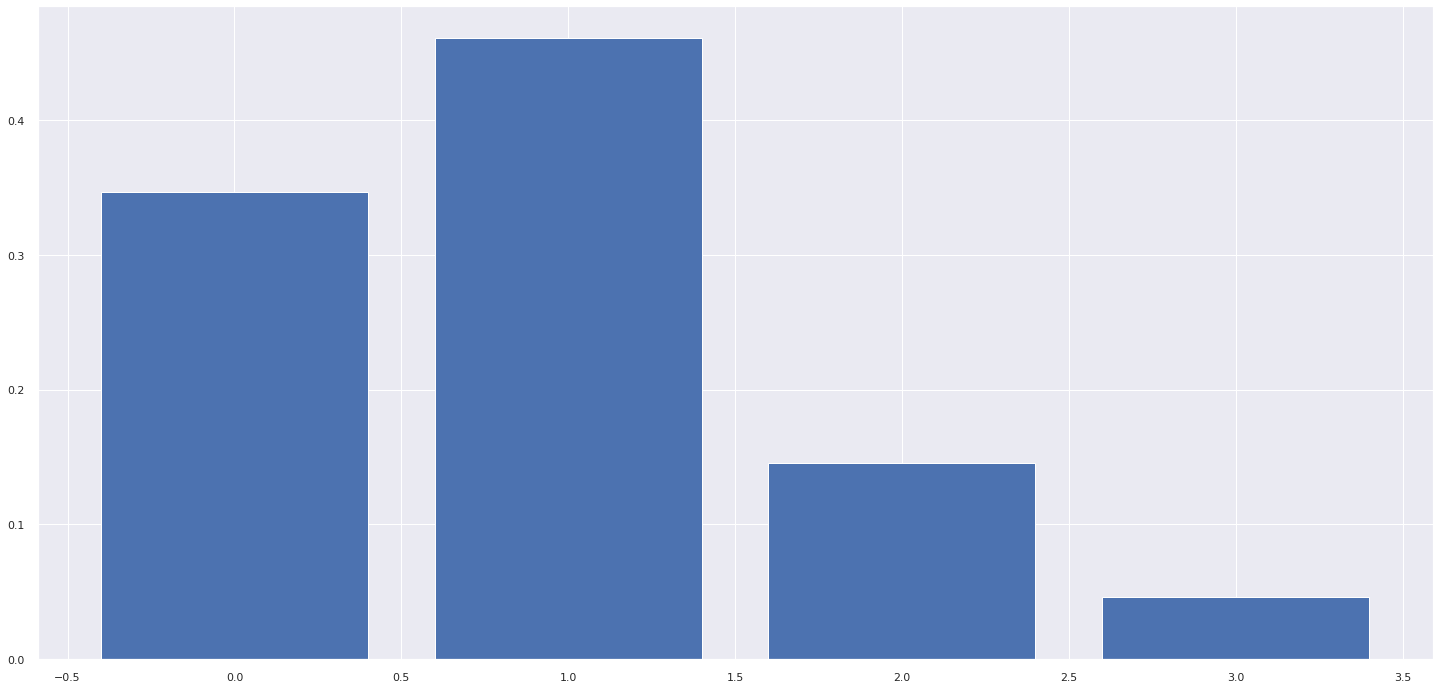

In [47]:
#df7
df7=df6[cols_selected_boruta_full].copy()
df7=df7[df7.index>100]

#X and y
y=df7['Exited']
X=df7.drop('Exited',axis=1)

#Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')

#transform
X_over, y_over = oversample.fit_resample(X, y)

#train and test split
x_train,x_test,y_train,y_test=train_test_split(X_over,y_over,random_state=100,test_size=0.2)

#Dataset Pycared
X_TRAIN=x_train.copy()
X_TRAIN['Existed']=y_train

#df_cross_validation
df_cross_validation=pd.concat([X_over, y_over],axis=1)

#Feature importance
feature_importance(X_over, y_over)

##7.1. Baseline

In [48]:
#Prediction
yhat_rendom=np.ones(len(y_test))

#Performance
baseline_result=model_performance(y_test,yhat_rendom,'Baseline')
baseline_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,Baseline,0.50,1.00,0.67,0.50


##7.2. Pycared

In [49]:
#Setup
s=setup( X_TRAIN[['Age', 'Balance', 'NumOfProducts', 'IsActiveMember','Existed']],
        target='Existed',
        numeric_features=['Age','Balance','NumOfProducts'],
        normalize=True,
        normalize_method='minmax',
        data_split_stratify=True,
        )

#Best models
best=compare_models(fold=5,sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.85,0.92,0.87,0.83,0.85,0.69,0.69,0.80
rf,Random Forest Classifier,0.84,0.91,0.88,0.81,0.85,0.68,0.68,0.97
lightgbm,Light Gradient Boosting Machine,0.78,0.87,0.77,0.78,0.78,0.56,0.56,0.19
gbc,Gradient Boosting Classifier,0.76,0.85,0.74,0.77,0.76,0.52,0.52,0.62
dt,Decision Tree Classifier,0.83,0.85,0.87,0.81,0.84,0.66,0.67,0.03
knn,K Neighbors Classifier,0.76,0.84,0.79,0.75,0.77,0.53,0.53,0.19
ada,Ada Boost Classifier,0.75,0.83,0.71,0.77,0.74,0.50,0.50,0.25
qda,Quadratic Discriminant Analysis,0.71,0.80,0.67,0.73,0.70,0.43,0.43,0.02
nb,Naive Bayes,0.72,0.79,0.68,0.74,0.71,0.44,0.44,0.02
lr,Logistic Regression,0.69,0.75,0.68,0.69,0.68,0.38,0.38,0.68


##7.3. Extra Trees Classifier

In [50]:
#Model
etc=ExtraTreesClassifier()
etc_train=etc.fit(x_train,y_train)

#Predict
yhat_etc=etc_train.predict(x_test)
yhat_etc_proba=etc_train.predict_proba(x_test)[:,1]

#Performance
etc_result=model_performance(y_test,yhat_etc,'ExtraTreesClassifier')
etc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,ExtraTreesClassifier,0.87,0.92,0.90,0.89


###7.3.1 Extra Trees Classifier cross validation

In [51]:
etc_result_cv=cross_validation(df_cross_validation,5,'ExtraTreesClassifier',etc,'Exited')
etc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,ExtraTreesClassifier,0.76+/-0.19,0.93+/-0.01,0.82+/-0.11,0.88+/-0.03


#8.0. HYPERPARAMETER FINE TUNING

In [52]:
df8=df7.copy()

##8.1.Random Search

In [53]:
#Params
params= {     'max_features':      ['auto', 'sqrt'],
              'min_samples_leaf':  [1, 2, 4, 6, 8, 10] ,
              'min_samples_split': [2, 5, 10, 15, 20],
              'max_depth' :        [int (x) for x in np.linspace (10, 110, num = 11)]}

#model
model_etc=ExtraTreesClassifier()

rscv = RandomizedSearchCV(model_etc, params, random_state=0,cv=3,n_iter=100).fit(x_train, y_train)
rscv.best_params_

{'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

##8.2.Final Model

In [54]:
#Params tuned
params_tuned={  'max_depth': 40,
                'max_features': 'sqrt',
                'min_samples_leaf': 1,
                'min_samples_split': 2}


#Model
etc_tuned=ExtraTreesClassifier(  max_depth=         params_tuned['max_depth'],
                                 max_features=      params_tuned['max_features'],
                                 min_samples_leaf=  params_tuned['min_samples_leaf'],
                                 min_samples_split= params_tuned['min_samples_split']
                                     )
                                
#Prediction
etc_tuned_train_final=etc_tuned.fit(x_train,y_train)
yhat_etc_tuned=etc_tuned_train_final.predict(x_test)

#Performance
etc_result=model_performance(y_test,yhat_etc_tuned,'ExtraTreesClassifier')
etc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,ExtraTreesClassifier,0.87,0.92,0.90,0.89


In [55]:
#Save trained model
final_model=etc_tuned.fit(X_over, y_over)
pickle.dump(final_model,open('final_model.pkl','wb'))

#9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [56]:
df9=df8.copy()

##9.1.Machine Learning Performance

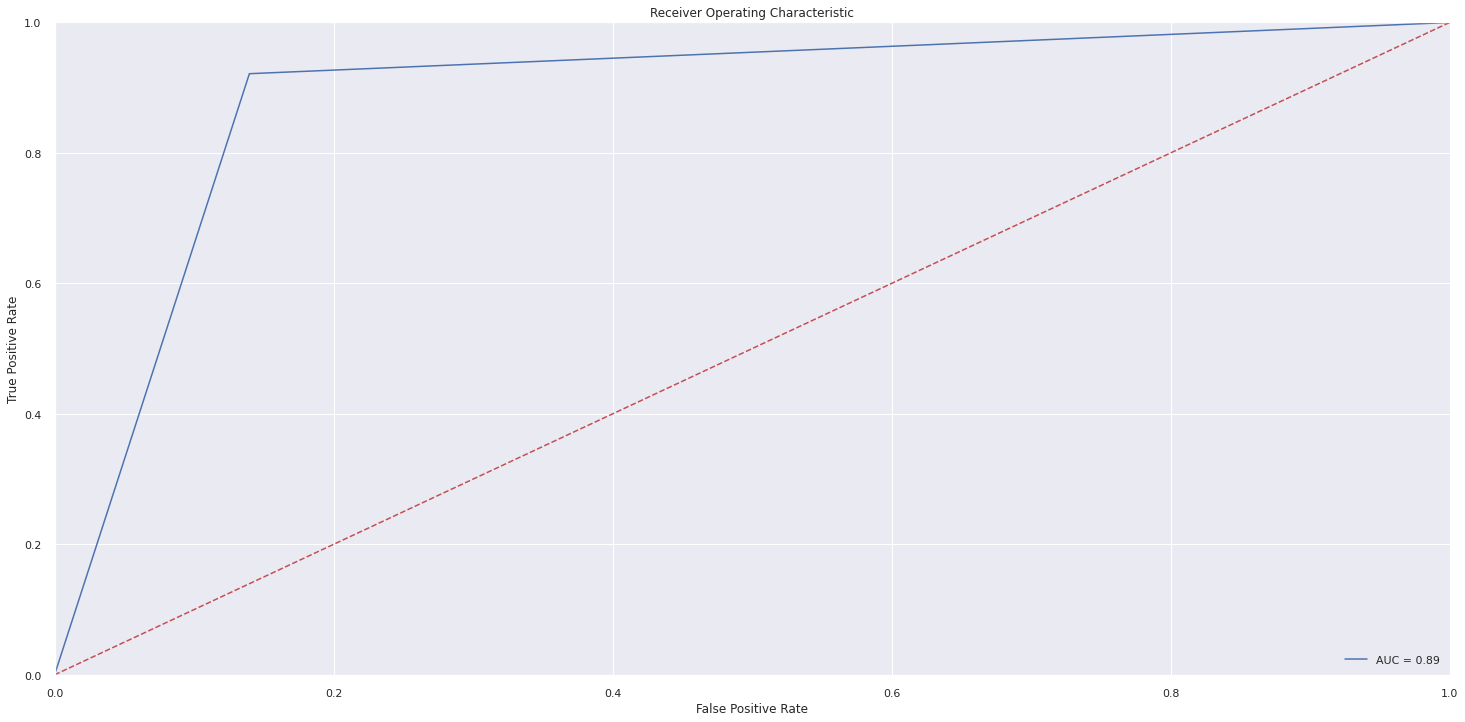

In [57]:
#AUC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_etc_tuned)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

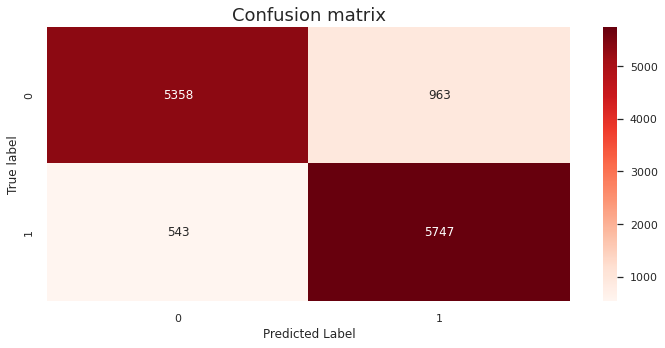

In [58]:
#Confusion matrix
np.random.seed(2811)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(etc_tuned , x_train, y_train, cv = cv)


fig, ax = plt.subplots()
ax=sns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt='d', cmap='Reds')
ax.figure.set_size_inches(10,5)
ax.set_title("Confusion matrix", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

##9.2.Business Performance

###Perguntas a serem respondidas:

####1- Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?

In [59]:
print('Taxa atual de Churn : {} %'.format(((df4[df4['Exited']==1].shape[0])*100)/df4.shape[0]))

Taxa atual de Churn : 20.37 %


####2- Qual a Performance do modelo em classificar os clientes como churns?

In [60]:
print('Recall : {}'.format(round(list(etc_result['Recall'])[0],2)))

Recall : 0.92


####3- Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

In [61]:
# Dataset com os clientes em churn
churn=df4[df4['Exited']==1]

# Recall alcancado
recall=0.92

# Extraindo 92% dos clientes em churn
numero_de_exemplos=int((recall*100*churn.shape[0])/100)
churn_identificado=churn.head(numero_de_exemplos)

#Aplicando a condicao de retorno financeiro do cliente
salario_estimado_medio=round(df4['EstimatedSalary'].mean(),2)
churn_identificado['FaturamentoAnual']=churn_identificado['EstimatedSalary']
churn_identificado['FaturamentoAnual']=churn_identificado['FaturamentoAnual'].apply(lambda x: x*0.15 if x<=salario_estimado_medio else
                                                                                              x*0.2  if x>salario_estimado_medio  else 0)

# Resultado
print('Valor de faturamento anual considerando a utilização do modelo com 92% dos churns identificados : R$ {}'.format(churn_identificado['FaturamentoAnual'].sum()))   

Valor de faturamento anual considerando a utilização do modelo com 92% dos churns identificados : R$ 35989726.4445


####4- Uma possível ação para evitar que o cliente entre em churn é oferecer um cupom de desconto, ou alguma outro incentivo financeiro para ele renovar seu contrato por mais 12 meses. Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00.

##### Valor R$ 250.

In [62]:
#Editando o dataset
aux=df4[df4['Exited']==1][['CustomerId','Surname','Balance','EstimatedSalary','Tenure']]

#Aplicando a condicao de retorno financeiro do cliente
salario_estimado_medio=round(df4['EstimatedSalary'].mean(),2)
aux['FaturamentoAnual']=aux['EstimatedSalary']
aux['FaturamentoAnual']=aux['FaturamentoAnual'].apply(lambda x: x*0.15 if x<=salario_estimado_medio else
                                                                x*0.2  if x>salario_estimado_medio  else 0)
#Faturamento total
aux['FaturamentoTotal']=aux['FaturamentoAnual']*aux['Tenure']

#Maiores clientes
aux=aux.sort_values('FaturamentoTotal',ascending=False).head(40)
aux

,CustomerId,Surname,Balance,EstimatedSalary,Tenure,FaturamentoAnual,FaturamentoTotal
2245,15578799,Anayolisa,53772.73,192072.10,10,38414.42,384144.20
5915,15725665,Lo,198546.10,191198.92,10,38239.78,382397.84
6827,15760216,Pokrovskaya,0.00,184474.72,10,36894.94,368949.44
5989,15601811,Caldwell,110240.04,183980.56,10,36796.11,367961.12
8088,15815656,Hopkins,100116.67,199808.10,9,39961.62,359654.58
4547,15672152,Grant,122506.38,199693.84,9,39938.77,359448.91
5087,15624641,Kharlamova,0.00,199290.68,9,39858.14,358723.22
2509,15689341,Gibbs,0.00,179267.94,10,35853.59,358535.88
2786,15585100,Rioux,124401.60,198814.24,9,39762.85,357865.63
6743,15616213,Levy,138214.50,198715.27,9,39743.05,357687.49


#10.0. DEPLOY MODEL TO PRODUCTION

##10.1. transformations class

In [63]:
'''import pandas as pd
import numpy  as np
import pickle

class transformations(object): 
  def __init__(self):    
    self.Age_scaler             =pickle.load(open('parameters/Age_scaler.pkl','rb'))
    self.Balance_scaler         =pickle.load(open('parameters/Balance_scaler.pkl','rb'))
    self.CreditScore_scaler     =pickle.load(open('parameters/CreditScore_scaler.pkl','rb'))
    self.EstimatedSalary_scaler =pickle.load(open('parameters/EstimatedSalary_scaler.pkl','rb'))
    self.NumOfProducts_scaler   =pickle.load(open('parameters/NumOfProducts_scaler.pkl','rb'))
    self.Tenure_scaler          =pickle.load(open('parameters/Tenure_scaler.pkl','rb'))
    self.IsActiveMember         =pickle.load(open('parameters/IsActiveMember_scaler.pkl','rb'))
    
     
     
  def data_cleaning(self,df1):  
    df1=df1.copy()

    #HasCrCard
    df1['HasCrCard']=df1['HasCrCard'].apply(lambda x: 'sim' if x==1 else 'nao')

    #IsActiveMember
    df1['IsActiveMember']=df1['IsActiveMember'].apply(lambda x: 'sim' if x==1 else 'nao')    
    
    return df1
  
  
  def feature_engeneering(self,df2):
    df2=df2.copy()

    #CreditScoreHigh
    df2['CreditScoreHigh']=df2['CreditScore'].apply(lambda x: 'maior' if x>=600 else 'menor')

    #EstimatedSalaryLow
    df2['EstimatedSalaryLow']=df2['EstimatedSalary'].apply(lambda x: 'maior' if x>=100000 else 'menor')

    #AgeHigh
    df2['AgeHigh']=df2['Age'].apply(lambda x: 'maior' if x>=50 else 'menor')

    #TenureLow
    df2['TenureLow']=df2['Tenure'].apply(lambda x: 'menor' if x<5 else 'maior')

    #BalanceLow
    df2['BalanceLow']=df2['Balance'].apply(lambda x: 'menor' if x<70000 else 'maior')

    #NumOfProductsHigh
    df2['NumOfProductsHigh']=df2['NumOfProducts'].apply(lambda x: 'menor' if x<2 else 'maior')
    

    return df2  
  

  def data_preparation(self,df5):
    df5=df5.copy()
    
    #CreditScore
    df5['CreditScore']=self.CreditScore_scaler.fit_transform(df5[['CreditScore']].values)    

    #Age
    df5['Age']=self.Age_scaler.fit_transform(df5[['Age']].values)    

    #Tenure
    df5['Tenure']=self.Tenure_scaler.fit_transform(df5[['Tenure']].values)    

    #Balance
    df5['Balance']=self.Balance_scaler.fit_transform(df5[['Balance']].values)    

    #NumOfProducts
    df5['NumOfProducts']=self.NumOfProducts_scaler.fit_transform(df5[['NumOfProducts']].values)    

    #EstimatedSalary
    df5['EstimatedSalary']=self.EstimatedSalary_scaler.fit_transform(df5[['EstimatedSalary']].values) 

    #IsActiveMember
    df5['IsActiveMember']=self.IsActiveMember.fit_transform(df5['IsActiveMember']) 

     
    
    
    df5=df5[['Age', 'Balance', 'NumOfProducts', 'IsActiveMember']]    
    
    return df5

  
  def get_prediction(self, model, dado_original, data_transforme):
    
    dado_original['Probability']=model.predict_proba(data_transforme)[:,1]

    return dado_original.to_json(orient='records',date_format='iso')   '''   

"import pandas as pd\nimport numpy  as np\nimport pickle\n\nclass transformations(object): \n  def __init__(self):    \n    self.Age_scaler             =pickle.load(open('parameters/Age_scaler.pkl','rb'))\n    self.Balance_scaler         =pickle.load(open('parameters/Balance_scaler.pkl','rb'))\n    self.CreditScore_scaler     =pickle.load(open('parameters/CreditScore_scaler.pkl','rb'))\n    self.EstimatedSalary_scaler =pickle.load(open('parameters/EstimatedSalary_scaler.pkl','rb'))\n    self.NumOfProducts_scaler   =pickle.load(open('parameters/NumOfProducts_scaler.pkl','rb'))\n    self.Tenure_scaler          =pickle.load(open('parameters/Tenure_scaler.pkl','rb'))\n    self.IsActiveMember         =pickle.load(open('parameters/IsActiveMember_scaler.pkl','rb'))\n    \n     \n     \n  def data_cleaning(self,df1):  \n    df1=df1.copy()\n\n    #HasCrCard\n    df1['HasCrCard']=df1['HasCrCard'].apply(lambda x: 'sim' if x==1 else 'nao')\n\n    #IsActiveMember\n    df1['IsActiveMember']=df1['IsA

In [64]:
'''#Dataframe de teste do deploy
df=df_raw.head(100)
df=df[df['Exited']==1]
df=df.drop(['Exited'],axis=1)

t=transformations()

df1=t.data_cleaning(df)

df2=t.feature_engeneering(df1)

data_transform=t.data_preparation(df2)

model=pickle.load(open('/content/mode_final.pkl','rb'))

t.get_prediction(model,df,data_transform)'''

"#Dataframe de teste do deploy\ndf=df_raw.head(100)\ndf=df[df['Exited']==1]\ndf=df.drop(['Exited'],axis=1)\n\nt=transformations()\n\ndf1=t.data_cleaning(df)\n\ndf2=t.feature_engeneering(df1)\n\ndata_transform=t.data_preparation(df2)\n\nmodel=pickle.load(open('/content/mode_final.pkl','rb'))\n\nt.get_prediction(model,df,data_transform)"

##10.2. API Handler

In [65]:
'''from flask                           import Flask,request,Response
from transformations.transformations import transformations
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/final_model.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #Isntantiate transformations
    pipeline=transformations()  

    #data cleaning
    df1=pipeline.data_cleaning(test_raw)  

    #feature engeneering
    df2=pipeline.feature_engeneering(df1)

    #data preparation
    df3=pipeline.data_preparation(df2)

    #predict
    df_response=pipeline.get_prediction(model,test_raw,df3)
    
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                           import Flask,request,Response\nfrom transformations.transformations import transformations\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/final_model.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      test_raw=pd.DataFrame(test_json,index=[0])\n\n    else:\n      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())\n    \n    #Isntantiate transformations\n    pipeline=transformations()  \n\n    #data cleaning\n    df1=pipeline.data_cleaning(test_raw)  \n\n    #feature engeneering\n    df2=pipeline.feature_engeneering(df1)\n\n    #data preparation\n    df3=pipeline.data_preparation(df2)\n\n    #predict\n    df_response=pipeline.get_prediction(model,test_raw,df3)\n    \n    return df_response\n\n  else:\n    retu

##10.3. API Tester

In [66]:
#Dataframe de teste do deploy
df=df_raw.head(100)
df=df[df['Exited']==1]
df=df.drop(['Exited'],axis=1)

#converter em json
df=json.dumps(df.to_dict(orient='records'))

#API call
path='https://sdfnsdfsdbbbb.herokuapp.com/'
url=path +'oi'
headers={'content-type':'application/json'}
data=df
r=requests.post(url,data=data,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [67]:
 #Prediction
df1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df1.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Probability
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,0.53
1,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,0.90
2,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,0.09
3,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,0.85
4,17,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,0.77
5,23,15699309,Gerasimov,510,Spain,Female,38,4,0.00,1,1,0,118913.53,0.56
6,31,15589475,Azikiwe,591,Spain,Female,39,3,0.00,3,1,0,140469.38,0.52
7,36,15794171,Lombardo,475,France,Female,45,0,134264.04,1,1,0,27822.99,0.64
8,42,15738148,Clarke,465,France,Female,51,8,122522.32,1,0,0,181297.65,0.67
9,44,15755196,Lavine,834,France,Female,49,2,131394.56,1,0,0,194365.76,0.63
